# Descriptive (Spatial) Analytics

Task: Analyze taxi demand patterns for the relevant one-year period and 
city (please check carefully which year your team has been allocated). Specifically show how these
patterns (start time, trip length, start and end location, price, average idle time between trips, and so 
on) for the given sample varies in different spatio-temporal resolution (i.e., census tract vs. varying
hexagon diameter and/or temporal bin sizes). Give possible reasons for the observed patterns

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import h3
import h3pandas
import geopandas as gpd
import seaborn as sns
from datetime import datetime
from time import mktime
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
import contextily as ctx

In [2]:
file_path = "./data/"

## Temporal Analysis

We first load in the prepared datasets and visualize it to see that everything looks ok

In [3]:
taxi_hourly = pd.read_csv(f"{file_path}taxi_hourly_processed.csv")
taxi_4hourly = pd.read_csv(f"{file_path}taxi_4_hourly_processed.csv")
taxi_daily = pd.read_csv(f"{file_path}taxi_daily_processed.csv")

In [4]:
taxi_daily.head(30)

trip_amount  mean_trip_seconds  mean_trip_miles  mean_trip_total  \
0          2717        1054.298859         6.099989        23.005425   
1          4118        1073.296989         5.963327        23.184310   
2          3639        1072.172025         7.379272        27.713858   
3          5668         991.735533         5.264190        20.399884   
4          5153         983.744033         4.752045        18.901547   
5          4906         984.262943         4.797923        18.819499   
6          5037         962.542783         4.580633        18.153163   
7          5031        1006.860664         4.765567        18.680302   
8          3739        1055.820273         5.299195        20.619321   
9          2920        1026.263699         6.484332        24.074120   
10         5325         930.841127         4.596783        18.172695   
11         4993         963.150010         4.484346        17.765652   
12         5162         964.154398         4.643479        18.146964   
13         5416         948.233936         4.415358        17.783261   
14         5311        1019.162305         4.770394        18.748014   
15         3515        1011.492176         5.034353        19.474256   
16         2695        1039.024861         6.068831        23.167777   
17         4636         992.603106         4.973149        19.802571   
18         5100         991.145098         4.803767        18.657871   
19         4669         954.893553         4.538621        17.983058   
20         4981         965.956635         4.425678        18.070833   
21         5284         965.588759         4.452935        17.861113   
22         3651        1085.531909         5.100077        20.044002   
23         2971        1008.613935         6.171811        23.612561   
24         5182         983.238711         4.819562        19.006129   
25         4275         981.283743         4.626538        18.580030   
26         5059         956.410951         4.480217        18.051073   
27         5618         926.171591         4.295910        17.527796   
28         5674         985.547585         4.443638        17.941606   
29         3807        1068.231153         4.830893        19.386654   

    start_temp  start_precip  start_windspeed  end_temp  end_precip  \
0     0.890291      0.444240        10.338907  0.925701    0.435407   
1     1.796574      0.000000         3.918924  1.772812    0.000000   
2     0.186678      0.022259         4.620239  0.078673    0.026381   
3    -1.312578      0.000000         5.855162 -1.260842    0.000000   
4     0.413514      0.000000         3.954648  0.414912    0.000000   
5     2.366284      0.000000         2.773394  2.385834    0.000000   
6     2.626321      0.000000         7.299021  2.615819    0.000000   
7     1.365820      0.000000         8.323437  1.349928    0.000000   
8     1.071984      0.000000         3.224135  1.077085    0.000000   
9    -1.124401      0.000000         4.239616 -1.189962    0.000000   
10   -1.836723      0.000000         9.045292 -1.795131    0.000000   
11    0.928472      0.000000         7.921885  0.956034    0.000000   
12    2.651356      0.000000         8.087639  2.673355    0.000000   
13    2.614308      0.278065         9.044513  2.608709    0.289882   
14    1.455099      0.000000         4.608558  1.431553    0.000000   
15    1.583787      0.010526         7.762683  1.564125    0.008819   
16   -0.353258      0.000000         3.675217 -0.354108    0.000000   
17   -1.246225      0.000000         7.350244 -1.270736    0.000000   
18   -1.225337      0.000000         8.187553 -1.179875    0.000000   
19   -2.862797      0.000000        11.325659 -2.734909    0.000000   
20    1.998538      0.000000        12.015724  2.007244    0.000000   
21   -6.464762      0.000000         8.578372 -6.485509    0.000000   
22   -2.509764      0.000000         4.724289 -2.412714    0.000000   
23    0.032572      0.000000         4.616903  0.032753    0.000000

### General Stats with Daily Data

We first visualize some general stats over the entire dataset using data aggregated to each day

We can see that the trip amount per day has a bimodal distribution, with a peak at around 5000 trips per a day and another one around 12500 trips per day

<AxesSubplot: xlabel='trip_amount', ylabel='Count'>

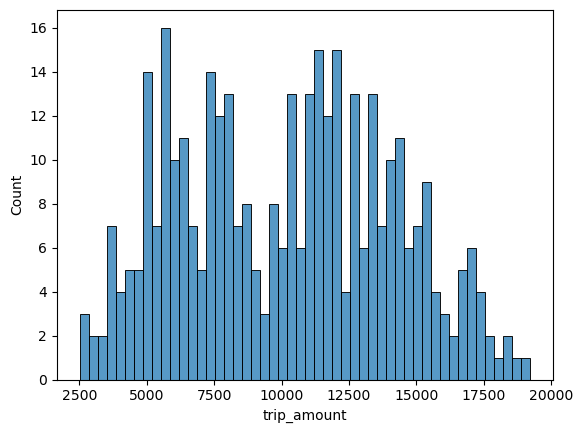

In [5]:
sns.histplot(data=taxi_daily, x="trip_amount", bins=50)

The peak at the mean trip length is about 1150 seconds or about 20 minutes

<AxesSubplot: xlabel='mean_trip_seconds', ylabel='Count'>

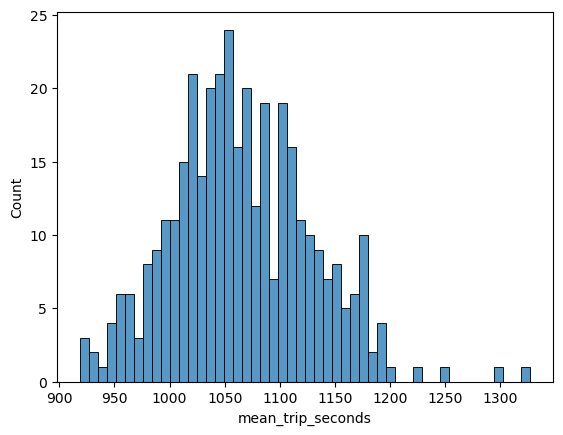

In [6]:
sns.histplot(data=taxi_daily, x="mean_trip_seconds", bins=50)

Peak of trip length seems to be about 5.5 miles or about 8.85 km

<AxesSubplot: xlabel='mean_trip_miles', ylabel='Count'>

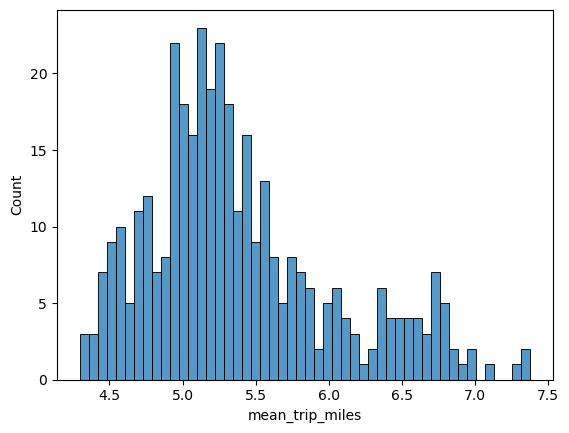

In [7]:
sns.histplot(data=taxi_daily, x="mean_trip_miles", bins=50)

The mode of the total for the trips seems to be around 22 dollars

<AxesSubplot: xlabel='mean_trip_total', ylabel='Count'>

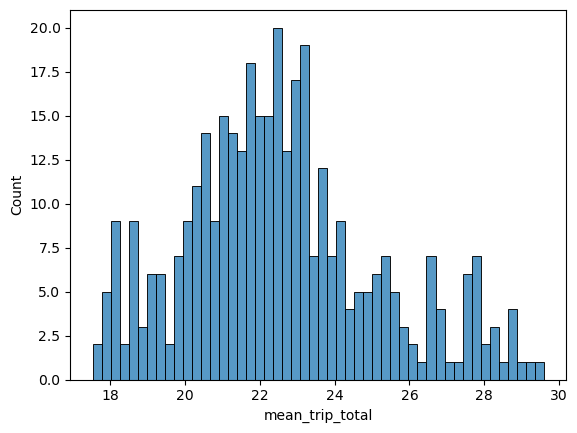

In [8]:
sns.histplot(data=taxi_daily, x="mean_trip_total", bins=50)

The starting temperature again seems to have a bimodal distribution with many trips at around 5 degrees and many around 20 degrees

<AxesSubplot: xlabel='start_temp', ylabel='Count'>

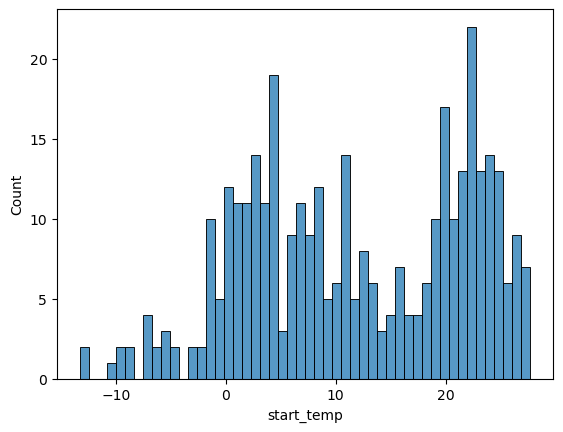

In [9]:
sns.histplot(data=taxi_daily, x="start_temp", bins=50)

Most trips are with no precipitation, but it is also expected, as it likely does not rain more often that it does rain and the average rain per day is also spread very thin

<AxesSubplot: xlabel='start_precip', ylabel='Count'>

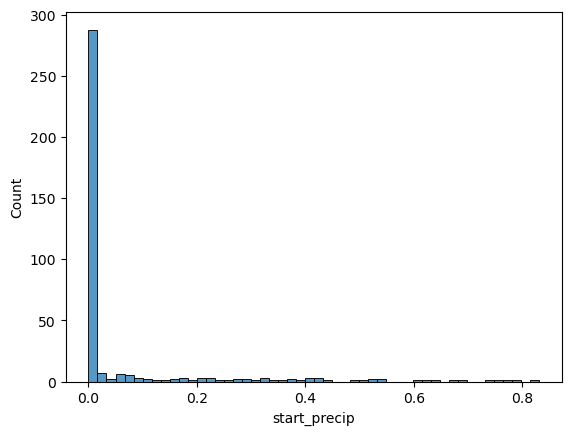

In [10]:
sns.histplot(data=taxi_daily, x="start_precip", bins=50)

### Daily Trends

Next we look at more specific trends over the entire year, again with daily data, but plotted so the yearly progression becomes obvious

Trip amount seem to increase sharply until very late in the year. One of the reasons of this could be the year 2021 and the covid restrictions at the start.

<AxesSubplot: ylabel='trip_amount'>

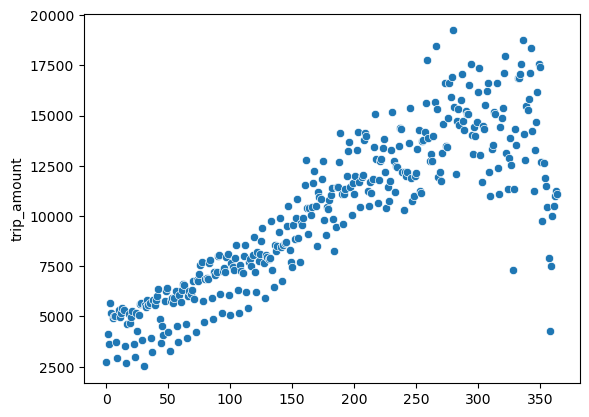

In [11]:
sns.scatterplot(data=taxi_daily, x=taxi_daily.index, y="trip_amount")

Looking at trip amounts when a day has a bit of rain and when it does not, no real trend can be immediately seen

<AxesSubplot: ylabel='trip_amount'>

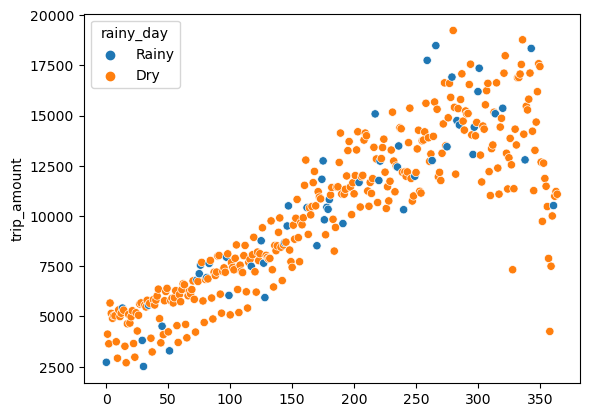

In [12]:
taxi_daily['rainy_day'] = (taxi_daily['start_precip'] >= 0.1).map({False: "Dry", True: "Rainy"})
sns.scatterplot(data=taxi_daily, x=taxi_daily.index, y="trip_amount", hue="rainy_day")

A trend can be seen that trip amount generally seems to increase with warmer weather, but it also increases later in the year, where it is warmer, so this might be a confounding factor

<AxesSubplot: ylabel='trip_amount'>

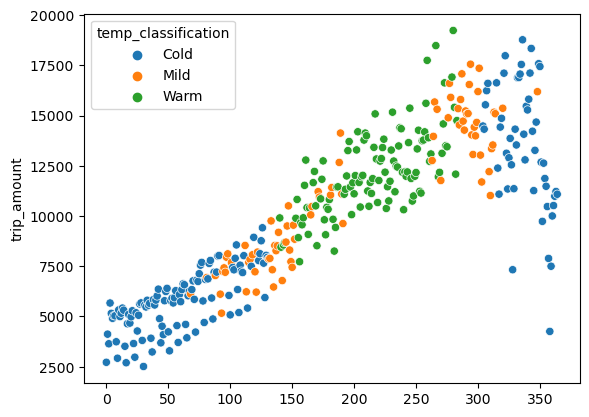

In [13]:
taxi_daily['temp_classification'] = taxi_daily["start_temp"].map(lambda x: "Warm" if x >= 20 else "Mild" if x > 10 else "Cold")
sns.scatterplot(data=taxi_daily, x=taxi_daily.index, y="trip_amount", hue="temp_classification")

For clarity, here is the general temperature curve for the year

<AxesSubplot: ylabel='start_temp'>

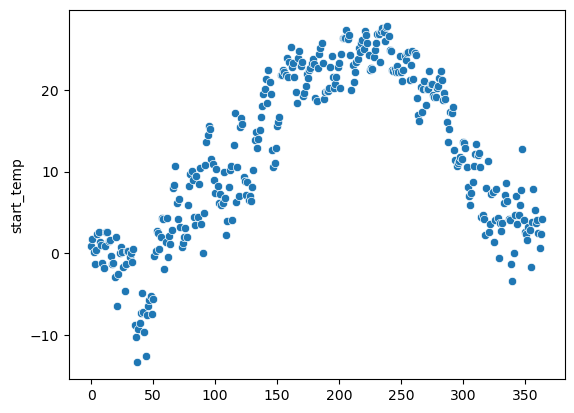

In [14]:
sns.scatterplot(data=taxi_daily, x=taxi_daily.index, y="start_temp")

What can be seen pretty clearly is a link between warm weather and trip length, with warm days having longer trips in general than cold days.

<AxesSubplot: ylabel='mean_trip_seconds'>

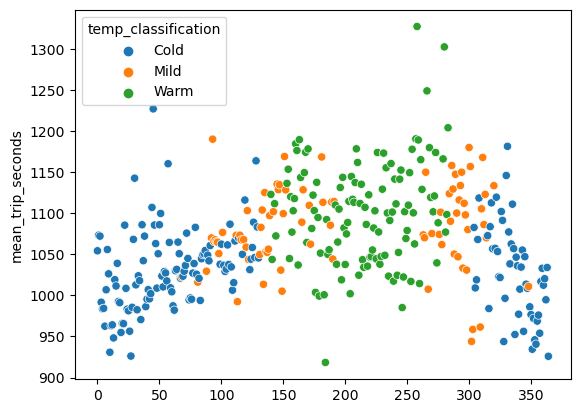

In [15]:
sns.scatterplot(data=taxi_daily, x=taxi_daily.index, y="mean_trip_seconds", hue="temp_classification")

### Inner-Day Trends

Next, we look at trends that can be seen in each day, for which we look at the dataset aggregating trips for every four hours

In [16]:
taxi_4hourly.head(10)

trip_amount  mean_trip_seconds  mean_trip_miles  mean_trip_total  \
0          224         843.897321         4.650223        18.166563   
1          156         880.012821         5.890128        20.501346   
2          434         970.311060         5.709309        21.174263   
3          761        1031.434954         5.424717        20.822365   
4          660        1138.340909         6.204561        23.832561   
5          482        1205.130705         8.116390        30.027552   
6          152         798.473684         6.259013        23.938684   
7          145         931.055172         6.059862        21.249034   
8          770        1055.472727         5.599792        20.918208   
9         1325        1119.788679         5.553494        21.641396   

   start_temp  start_precip  start_windspeed  end_temp  end_precip  \
0   -1.285045      0.000000         6.953839 -1.271652    0.000000   
1   -0.423013      0.000000         9.206667 -0.350577    0.000000   
2    0.196382      0.320276        10.717788  0.265092    0.398618   
3    1.218962      1.000000        11.249829  1.262208    0.923784   
4    1.536242      0.231818        11.083439  1.521591    0.303030   
5    1.547676      0.319502         9.479668  1.607531    0.221992   
6    1.950921      0.000000         9.240132  1.896316    0.000000   
7    1.381172      0.000000         4.991379  1.497862    0.000000   
8    2.251286      0.000000         3.237818  2.269117    0.000000   
9    2.202279      0.000000         2.914332  2.143698    0.000000   

   end_windspeed  
0       7.024420  
1       9.417756  
2      10.765023  
3      11.304350  
4      10.849333  
5       9.611535  
6       8.925724  
7       4.890828  
8       3.085403  
9       3.053419

For ease of use, we extract the start hour from the dataset into a separate column and give it a more descriptive name

In [17]:
taxi_4hourly["start_hour"] = taxi_4hourly.index.map(lambda x: (x % 6) * 4)
taxi_4hourly["time_of_day"] = taxi_4hourly["start_hour"].map(lambda x: "Morning" if x == 8  else "Noon" if x == 12 else "Afternoon" if x == 16 else "Evening" if x == 20 else "Night" if x == 0 else "Early Morning")
taxi_4hourly.head(10)

trip_amount  mean_trip_seconds  mean_trip_miles  mean_trip_total  \
0          224         843.897321         4.650223        18.166563   
1          156         880.012821         5.890128        20.501346   
2          434         970.311060         5.709309        21.174263   
3          761        1031.434954         5.424717        20.822365   
4          660        1138.340909         6.204561        23.832561   
5          482        1205.130705         8.116390        30.027552   
6          152         798.473684         6.259013        23.938684   
7          145         931.055172         6.059862        21.249034   
8          770        1055.472727         5.599792        20.918208   
9         1325        1119.788679         5.553494        21.641396   

   start_temp  start_precip  start_windspeed  end_temp  end_precip  \
0   -1.285045      0.000000         6.953839 -1.271652    0.000000   
1   -0.423013      0.000000         9.206667 -0.350577    0.000000   
2    0.196382      0.320276        10.717788  0.265092    0.398618   
3    1.218962      1.000000        11.249829  1.262208    0.923784   
4    1.536242      0.231818        11.083439  1.521591    0.303030   
5    1.547676      0.319502         9.479668  1.607531    0.221992   
6    1.950921      0.000000         9.240132  1.896316    0.000000   
7    1.381172      0.000000         4.991379  1.497862    0.000000   
8    2.251286      0.000000         3.237818  2.269117    0.000000   
9    2.202279      0.000000         2.914332  2.143698    0.000000   

   end_windspeed  start_hour    time_of_day  
0       7.024420           0          Night  
1       9.417756           4  Early Morning  
2      10.765023           8        Morning  
3      11.304350          12           Noon  
4      10.849333          16      Afternoon  
5       9.611535          20        Evening  
6       8.925724           0          Night  
7       4.890828           4  Early Morning  
8       3.085403           8        Morning  
9       3.053419          12           Noon

We start by looking at the length of the trips for each group. The early morning seems to stand out for its long trip length and the afternoon and morning for its much shorter length, which could indicate commuting.

<AxesSubplot: xlabel='mean_trip_miles', ylabel='Count'>

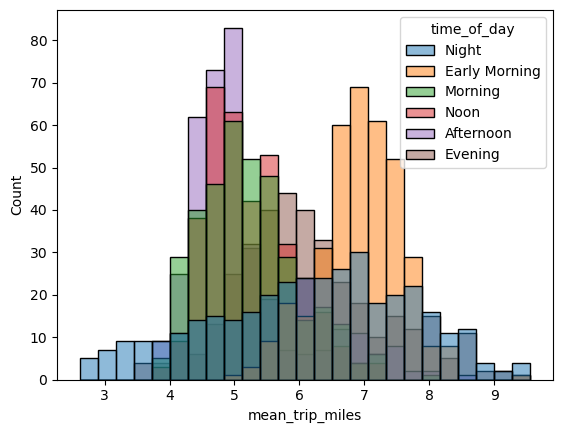

In [18]:
sns.histplot(data=taxi_4hourly, x="mean_trip_miles", hue="time_of_day")

Interestingly, the early morning routes dont seem to be much longer in terms of time, while the afternoon trips seem to be longer. This is likely due to low traffic in the early morning and high traffic in the afternoon.

<AxesSubplot: xlabel='mean_trip_seconds', ylabel='Count'>

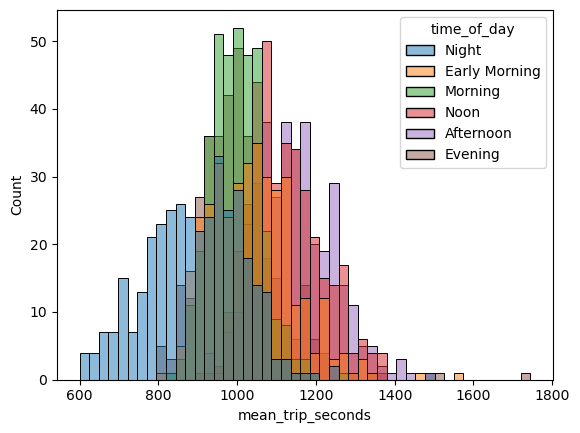

In [19]:
sns.histplot(data=taxi_4hourly, x="mean_trip_seconds", hue="time_of_day")

The early morning and night trips seem to be the most expensive ones. 

<AxesSubplot: xlabel='mean_trip_total', ylabel='Count'>

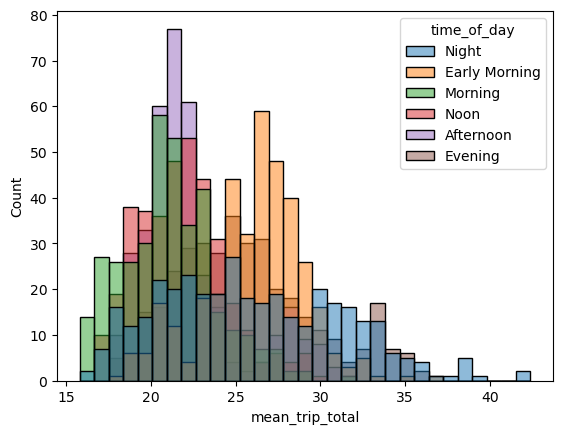

In [20]:
sns.histplot(data=taxi_4hourly, x="mean_trip_total", hue="time_of_day")

Morning, noon and afternoon have a lot more trips than early morning and the night, which seems logical

<AxesSubplot: xlabel='trip_amount', ylabel='Count'>

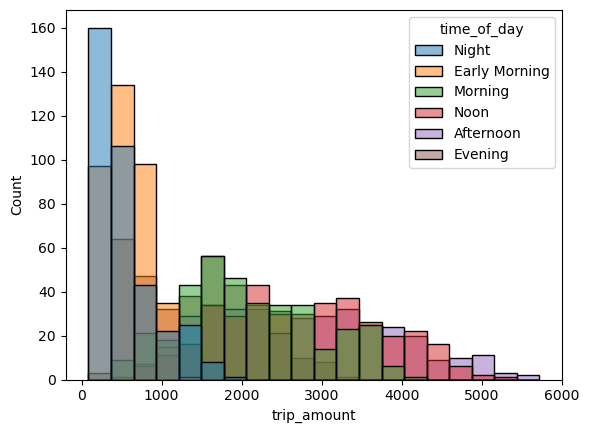

In [21]:
sns.histplot(data=taxi_4hourly, x="trip_amount", hue="time_of_day")

### Hourly Trends

Next, we look at trends in a day, but for each hour.

In [22]:
taxi_hourly["start_hour"] = taxi_hourly.index.map(lambda x: x % 24)
taxi_hourly_agg = taxi_hourly.groupby("start_hour").agg({"trip_amount" : "sum", "mean_trip_seconds" : "mean", "mean_trip_miles" : "mean", "mean_trip_total" : "mean", "start_temp" : "mean", "start_precip" : "mean", "start_windspeed" : "mean"})
taxi_hourly_agg.head(10)

trip_amount  mean_trip_seconds  mean_trip_miles  mean_trip_total  \
start_hour                                                                     
0                 75332         928.280771         6.446510        26.922824   
1                 54291         899.158644         6.097827        26.270430   
2                 34724         844.238685         5.600194        23.658640   
3                 23624         849.997389         6.116706        24.049733   
4                 21070         934.001445         7.478759        27.554955   
5                 31871        1028.227531         8.030483        28.924348   
6                 55792        1039.792207         7.445118        27.497745   
7                 98768        1073.629888         6.508235        24.723796   
8                152103        1011.574348         5.553077        22.057325   
9                183168         975.831223         5.192394        20.985180   

            start_temp  start_precip  start_windspeed  
start_hour                                             
0            10.015726      0.054795         7.417397  
1             9.830822      0.052055         7.300027  
2             9.634329      0.041096         7.180356  
3             9.452575      0.043836         7.065205  
4             9.296466      0.035616         6.949644  
5             9.312000      0.041096         6.838274  
6             9.574110      0.057534         6.694082  
7            10.096630      0.043836         6.596548  
8            10.880082      0.046575         6.667507  
9            11.624548      0.046575         6.730630

Here we see the observed trend that morning, noon and afternoon have the most trips visualized differently.  

<AxesSubplot: xlabel='start_hour', ylabel='trip_amount'>

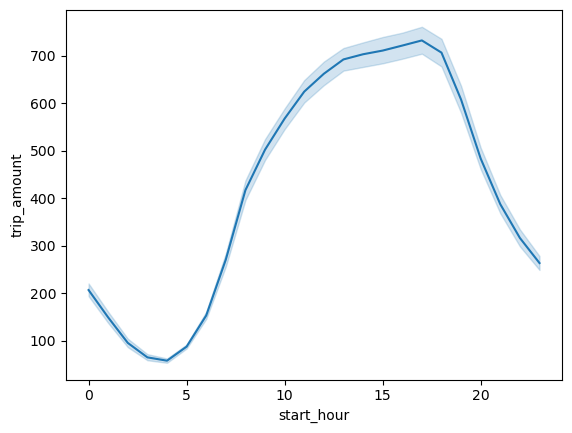

In [23]:
sns.lineplot(data=taxi_hourly, x="start_hour", y="trip_amount")

Here we see the much longer trips in the early morning

<AxesSubplot: xlabel='start_hour', ylabel='mean_trip_miles'>

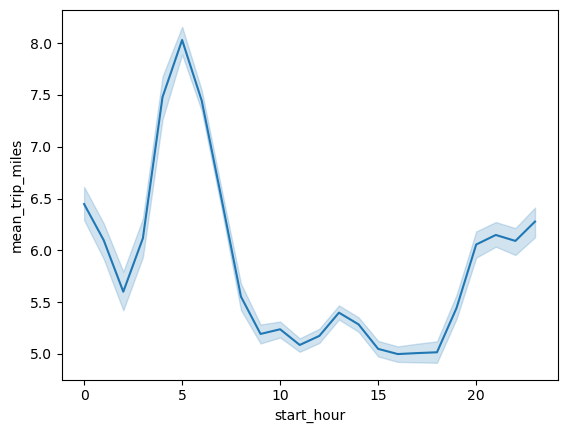

In [24]:
sns.lineplot(data=taxi_hourly, x="start_hour", y="mean_trip_miles")

The length of the trips in time here shows the long trips likely due to the traffic in the afternoon and longer trips in the early morning, but these have a high variance.

<AxesSubplot: xlabel='start_hour', ylabel='mean_trip_seconds'>

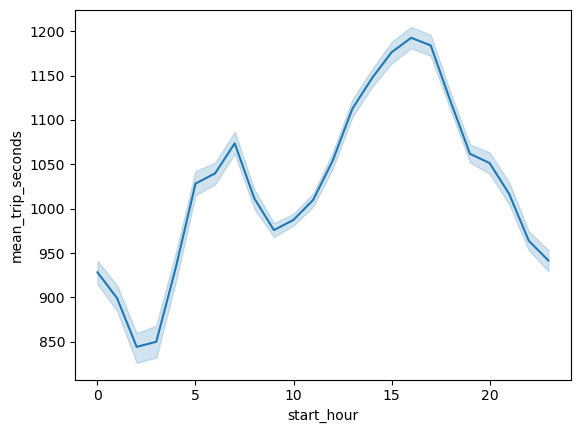

In [25]:
sns.lineplot(data=taxi_hourly, x="start_hour", y="mean_trip_seconds")

Evening, night and early morning trips seem much more expensive than noon and afternoon trips

<AxesSubplot: xlabel='start_hour', ylabel='mean_trip_total'>

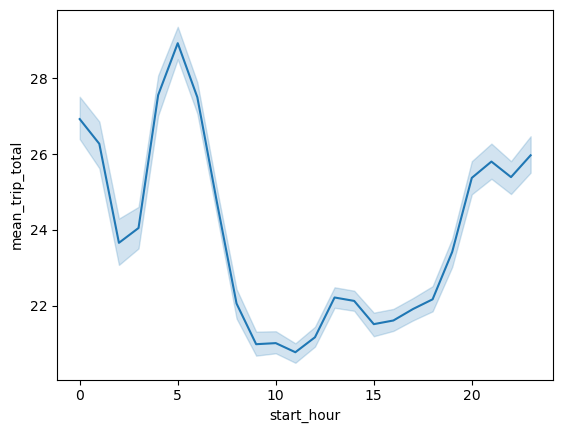

In [26]:
sns.lineplot(data=taxi_hourly, x="start_hour", y="mean_trip_total")

It is hard to see a significant trend to whether people use the taxi more when it is rainy or when it is dry. Rainy hours seem slightly more frequented than dry hours, but they also have a much higher variance.

<AxesSubplot: xlabel='start_hour', ylabel='trip_amount'>

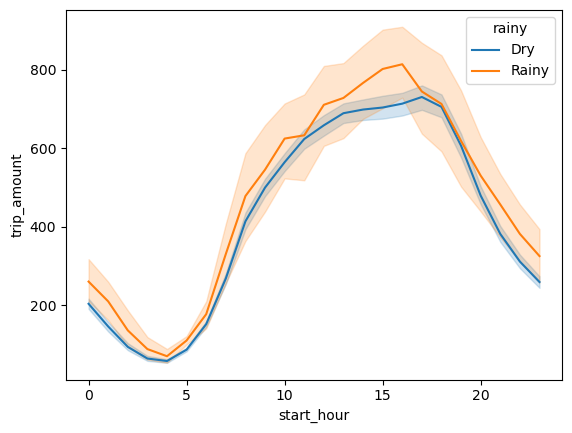

In [27]:
taxi_hourly['rainy'] = taxi_hourly["start_precip"].map(lambda x: "Rainy" if x > 0.5 else "Dry")
sns.lineplot(data=taxi_hourly, x="start_hour", y="trip_amount", hue="rainy")

Temperature however seems to correlate with trip amounts, but it is not clear whether that is not due to the time of the year. 

<AxesSubplot: xlabel='start_hour', ylabel='trip_amount'>

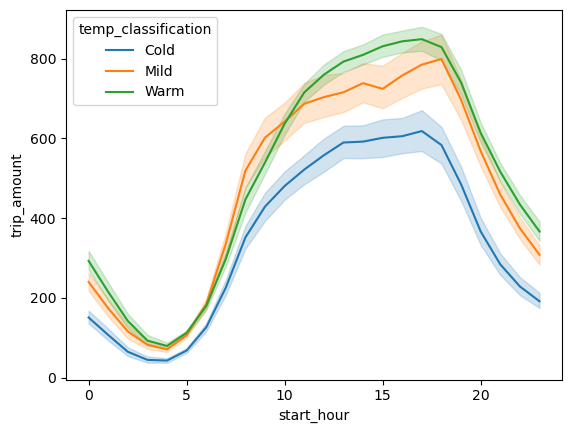

In [28]:
taxi_hourly['temp_classification'] = taxi_hourly["start_temp"].map(lambda x: "Warm" if x >= 20 else "Mild" if x > 10 else "Cold")
sns.lineplot(data=taxi_hourly, x="start_hour", y="trip_amount", hue="temp_classification")

## Spatial Analysis

Now we move on to visualizing geographical trends. For that we start by importing the prepared datasets and converting them to geodataframes

In [29]:
taxi_by_census_tract = pd.read_csv(f"{file_path}taxi_by_census_tract.csv")
taxi_by_community_area = pd.read_csv(f"{file_path}taxi_by_community_area.csv")
taxi_by_h3_6 = pd.read_csv(f"{file_path}taxi_by_h3_6.csv")
taxi_by_h3_7 = pd.read_csv(f"{file_path}taxi_by_h3_7.csv")
taxi_by_h3_8 = pd.read_csv(f"{file_path}taxi_by_h3_8.csv")

In [30]:
taxi_by_census_tract['geometry'] = gpd.GeoSeries.from_wkt(taxi_by_census_tract['geometry'])
taxi_by_census_tract_gpd = gpd.GeoDataFrame(taxi_by_census_tract, geometry="geometry")
taxi_by_community_area['geometry'] = gpd.GeoSeries.from_wkt(taxi_by_community_area['geometry'])
taxi_by_community_area_gpd = gpd.GeoDataFrame(taxi_by_community_area, geometry="geometry")
taxi_h3_6_gpd = taxi_by_h3_6.set_index("h3_6_pickup").h3.h3_to_geo_boundary()
taxi_h3_7_gpd = taxi_by_h3_7.set_index("h3_7_pickup").h3.h3_to_geo_boundary()
taxi_h3_8_gpd = taxi_by_h3_8.set_index("h3_8_pickup").h3.h3_to_geo_boundary()
taxi_h3_6_gpd.head(5)

trip_amount_pickup  mean_trip_seconds  mean_trip_miles  \
h3_6_pickup                                                               
862664197ffffff               10934        1401.645327         9.073257   
8626641b7ffffff                3054        1762.617551         8.351588   
862664527ffffff              120683        1565.060605         9.470445   
86266452fffffff                5721        1860.701276         6.848481   
862664567ffffff               33208        1354.609371         9.264621   

                 mean_trip_total  start_temp  start_precip  start_windspeed  \
h3_6_pickup                                                                   
862664197ffffff        28.867198   11.809961      0.055515         7.069226   
8626641b7ffffff        29.271853   12.553893      0.063851         7.071847   
862664527ffffff        39.959034   14.621903      0.067491         6.960829   
86266452fffffff        26.378724   12.836296      0.055060         7.020234   
862664567ffffff        29.009060   12.466658      0.052186         6.962850   

                  end_temp  end_precip  end_windspeed  trip_amount_dropoff  \
h3_6_pickup                                                                  
862664197ffffff  11.849291    0.053594       7.089692                 8153   
8626641b7ffffff  12.487809    0.065815       7.105956                 1634   
862664527ffffff  14.562111    0.067151       6.981360                48016   
86266452fffffff  12.901026    0.056808       7.042984                 6171   
862664567ffffff  12.514847    0.051674       6.978872                32906   

                 trip_amount_balance  \
h3_6_pickup                            
862664197ffffff                -2781   
8626641b7ffffff                -1420   
862664527ffffff               -72667   
86266452fffffff                  450   
862664567ffffff                 -302   

                                                          geometry  
h3_6_pickup                                                         
862664197ffffff  POLYGON ((-87.54846 41.70939, -87.59060 41.696...  
8626641b7ffffff  POLYGON ((-87.50168 41.75446, -87.54387 41.741...  
862664527ffffff  POLYGON ((-87.77440 41.82876, -87.81657 41.816...  
86266452fffffff  POLYGON ((-87.74113 41.77636, -87.78326 41.763...  
862664567ffffff  POLYGON ((-87.62819 41.71671, -87.67030 41.704...

In [31]:
import matplotlib.colors as colors
def plot_gpd(gpd, column, label, has_two_slope = False, color_scheme = 'coolwarm', show_legend=True):
    if has_two_slope: 
        return gpd.plot(legend=show_legend, column=column, figsize=(10, 10), norm=colors.TwoSlopeNorm(vmin=gpd[column].min(), vcenter=0, vmax=gpd[column].max()), cmap=color_scheme, legend_kwds = {'label': label})
    else:
        return gpd.plot(legend=show_legend, column=column, figsize=(10, 10), cmap=color_scheme, legend_kwds = {'label': label})

### Trips started

We first look at the trips started (so trip demand) for each geographical area. We visualize this in every spatial dimension, so community area, census tract and h3 in resolutions six, seven and eight. 

<AxesSubplot: >

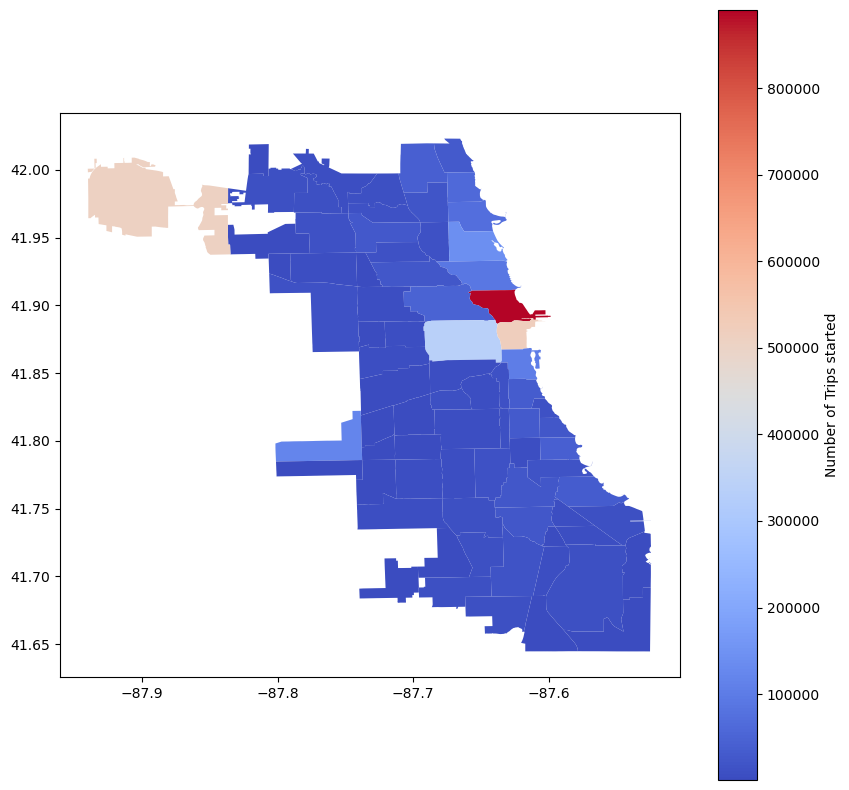

In [32]:
plot_gpd(taxi_by_community_area_gpd, "trip_amount_pickup", "Number of Trips started", False)

<AxesSubplot: >

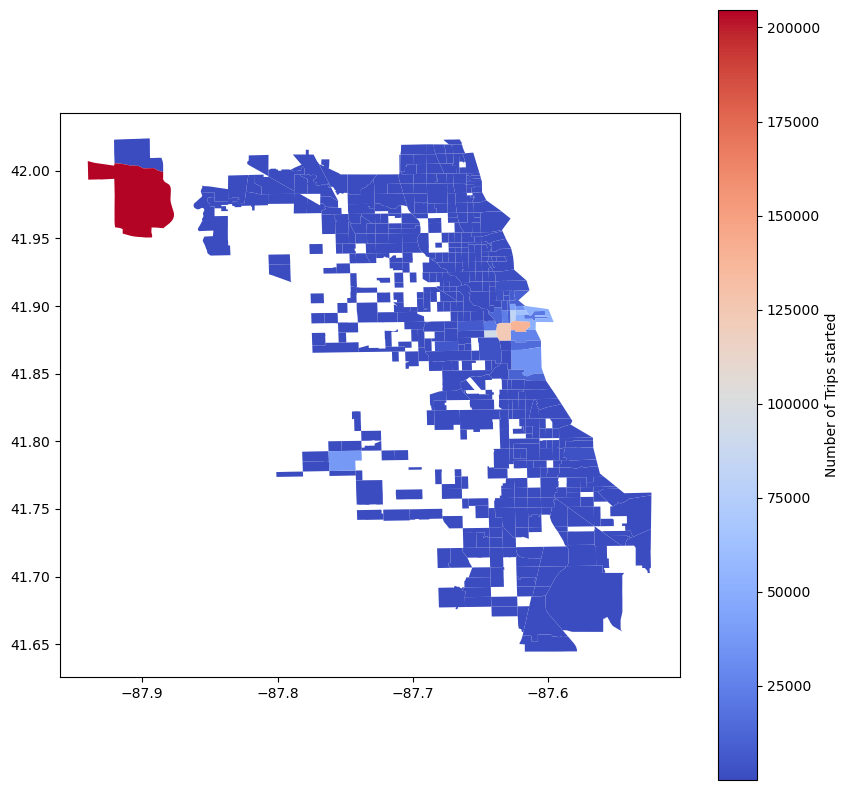

In [33]:
plot_gpd(taxi_by_census_tract_gpd, "trip_amount_pickup", "Number of Trips started", False)

<AxesSubplot: >

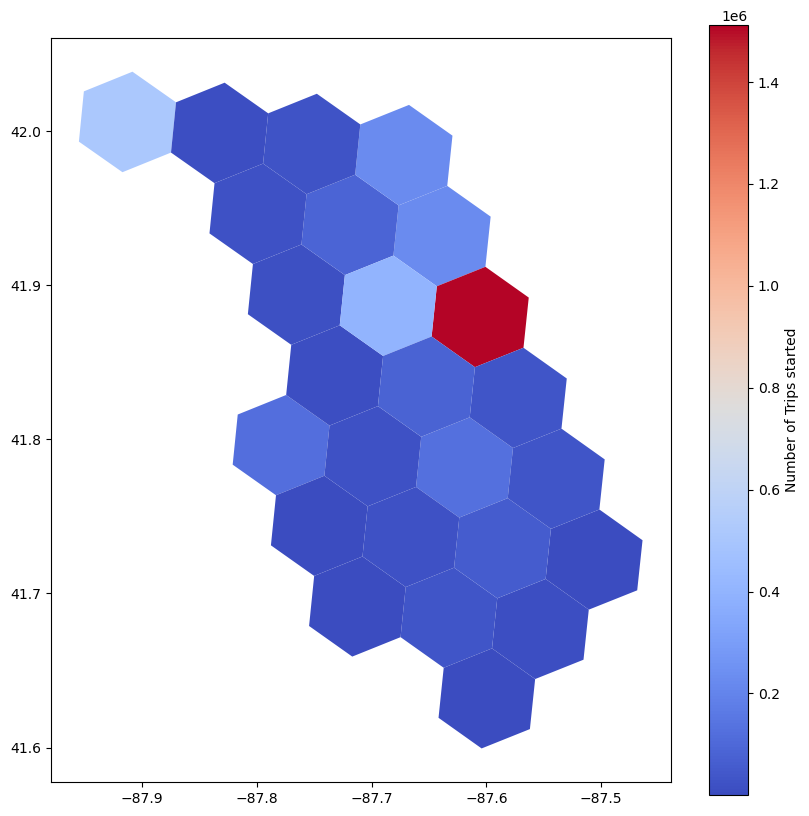

In [34]:
plot_gpd(taxi_h3_6_gpd, "trip_amount_pickup", "Number of Trips started", False)

<AxesSubplot: >

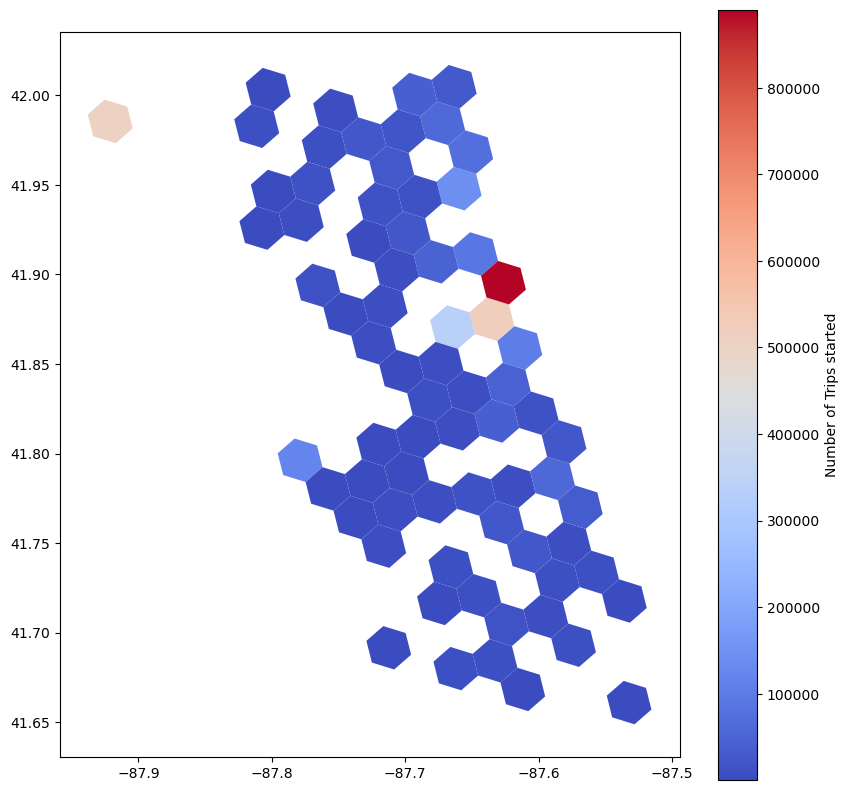

In [35]:
plot_gpd(taxi_h3_7_gpd, "trip_amount_pickup", "Number of Trips started", False)

<AxesSubplot: >

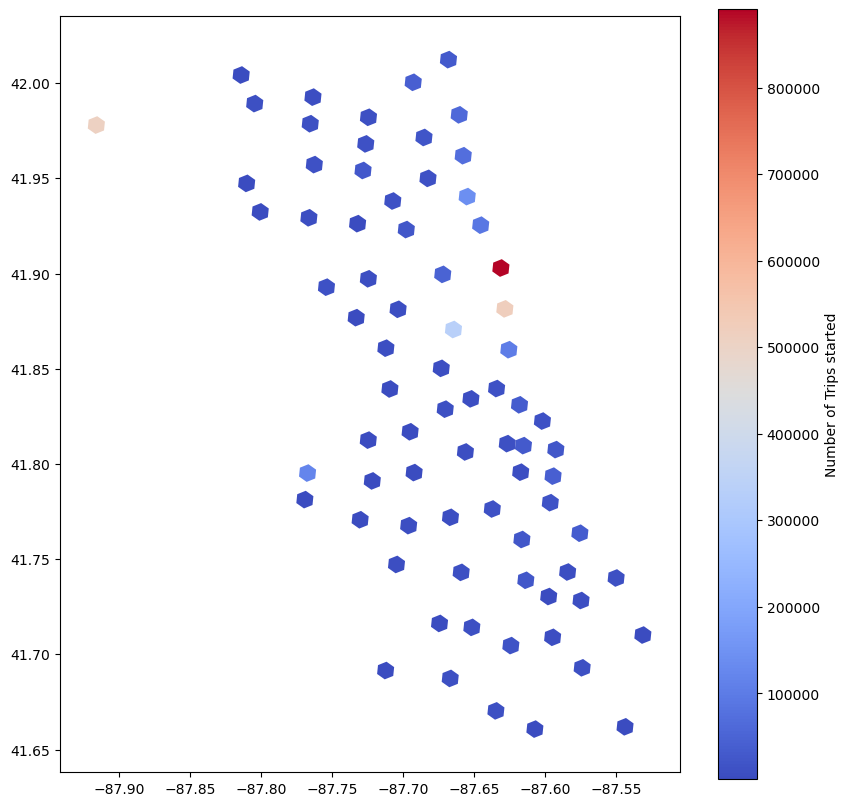

In [36]:
plot_gpd(taxi_h3_8_gpd, "trip_amount_pickup", "Number of Trips started", False)

We can clearly see that trip demand is concentrated in the inner city and some close surrounding areas, with demand becoming less the further away from that centre we go.
The only exception seems to be the northeastern area, where there is supposedly close to as much demand as in the inner city. This seems unusual and we suspect that trips beginning and end out of the city boundaries all get assigned to that district. 

### Trips ended

Next we analyze where trips end

<AxesSubplot: >

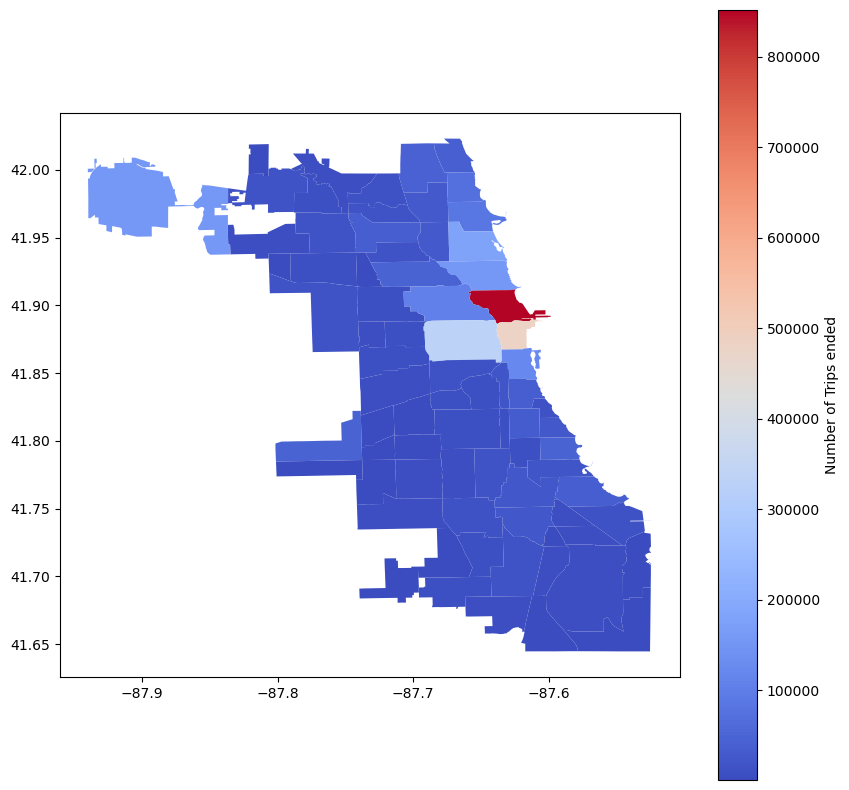

In [37]:
plot_gpd(taxi_by_community_area_gpd, "trip_amount_dropoff", "Number of Trips ended", False)

<AxesSubplot: >

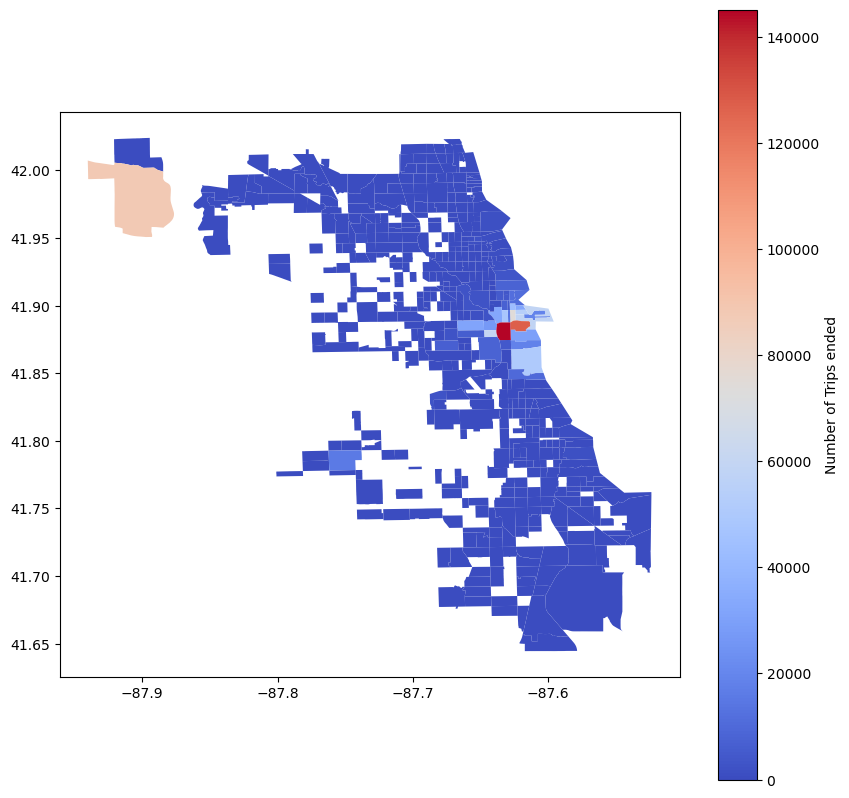

In [38]:
plot_gpd(taxi_by_census_tract_gpd, "trip_amount_dropoff", "Number of Trips ended", False)

<AxesSubplot: >

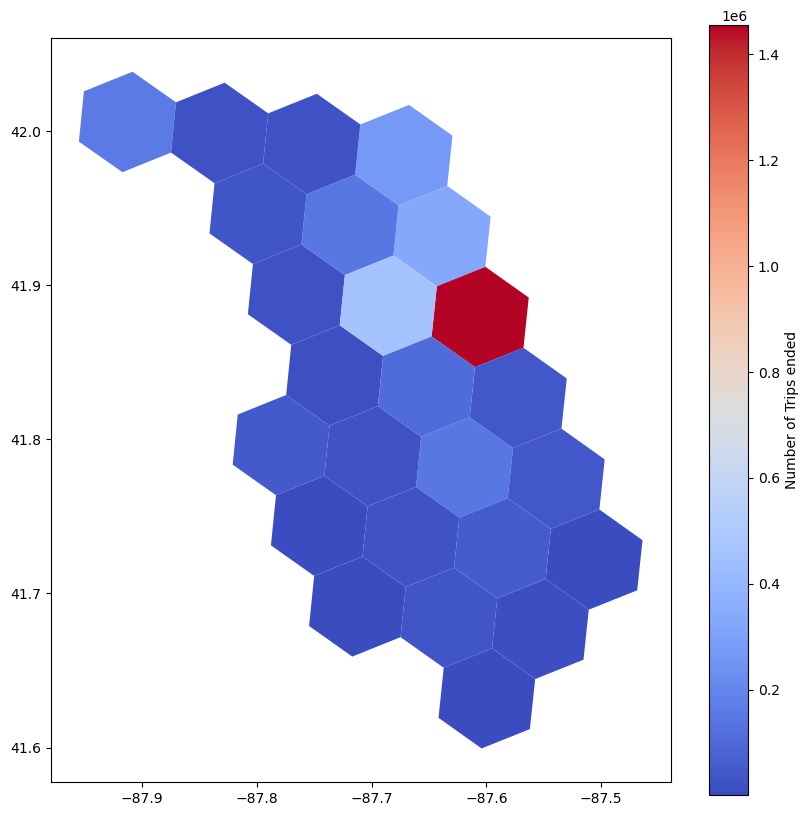

In [39]:
plot_gpd(taxi_h3_6_gpd, "trip_amount_dropoff", "Number of Trips ended", False)

<AxesSubplot: >

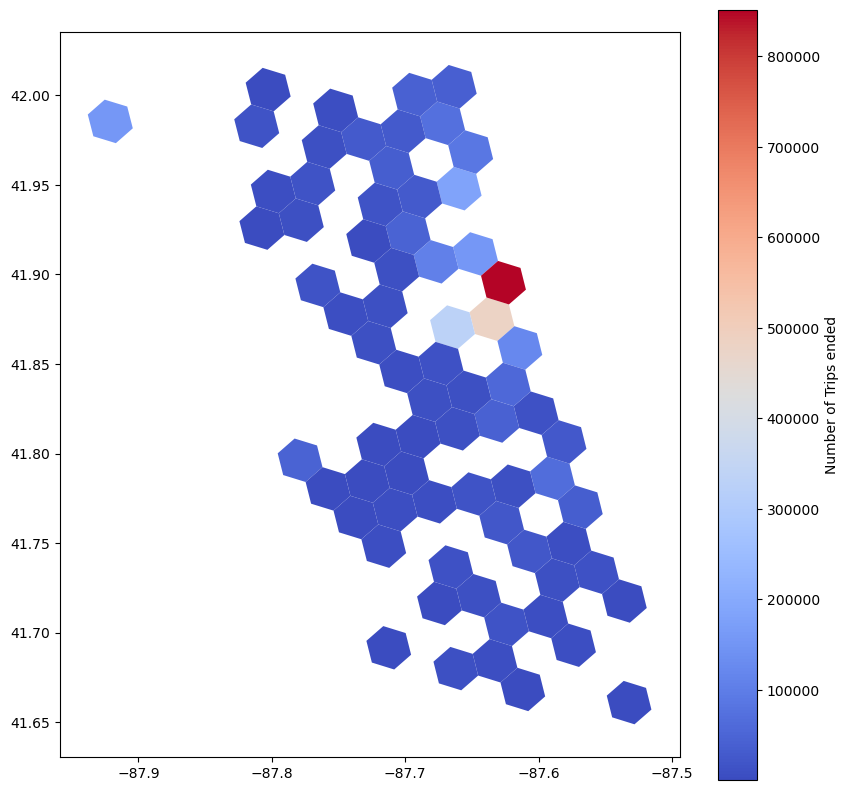

In [40]:
plot_gpd(taxi_h3_7_gpd, "trip_amount_dropoff", "Number of Trips ended", False)

<AxesSubplot: >

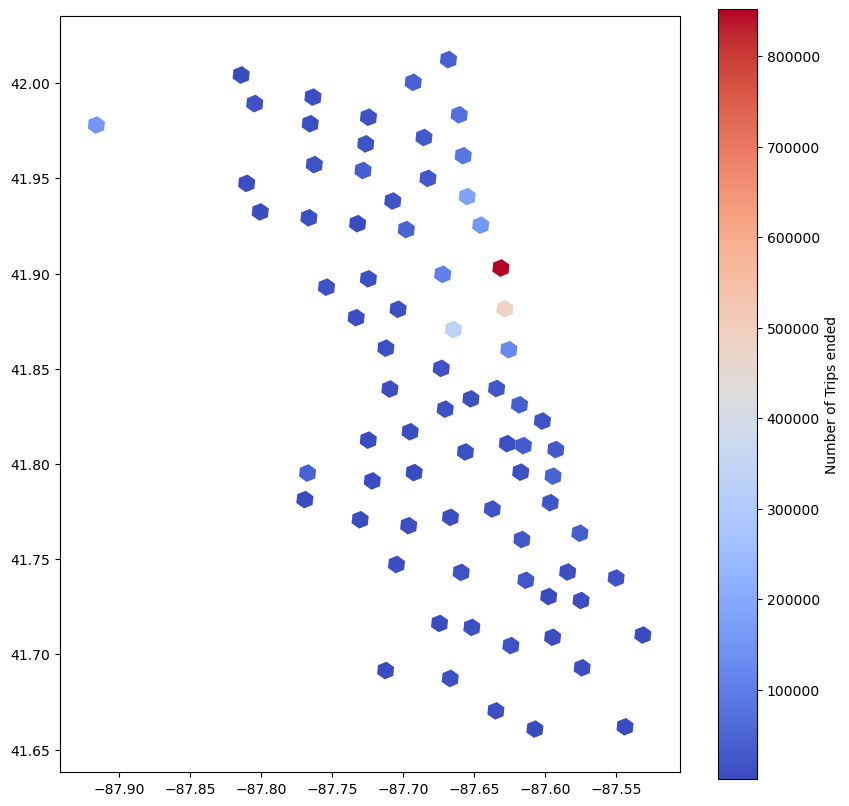

In [41]:
plot_gpd(taxi_h3_8_gpd, "trip_amount_dropoff", "Number of Trips ended", False)

It is hard to compare this to the amount of trips started somewhere, because it looks very similar to the trip starts, which is why next up we compare the amount of trip ends minus the amount of trip starts, so the balance in an area.

### Trip balance

<AxesSubplot: >

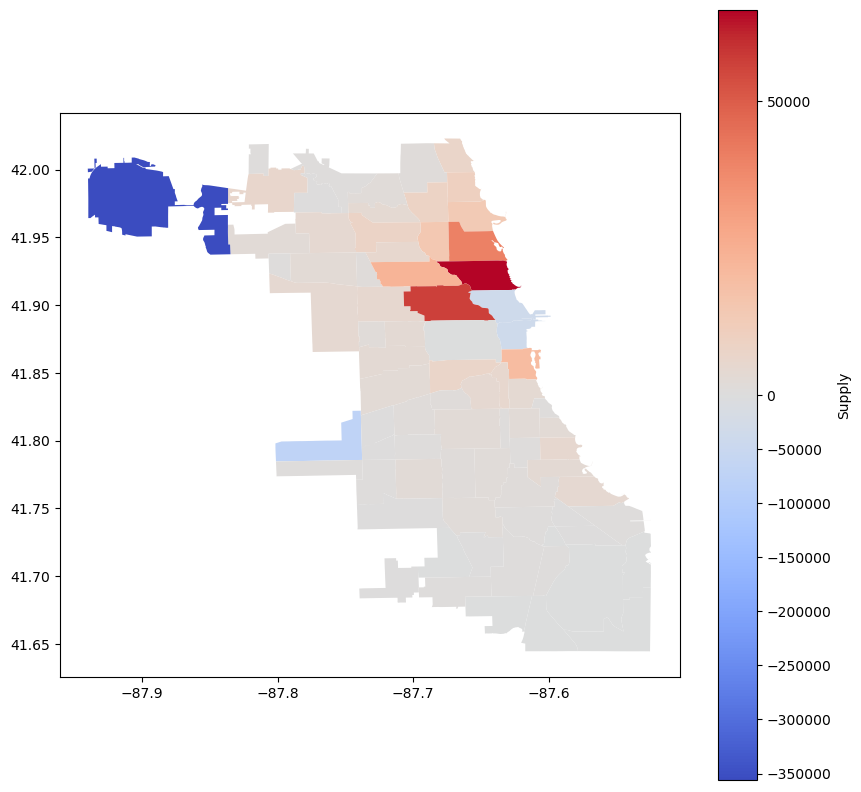

In [42]:
plot_gpd(taxi_by_community_area_gpd, "trip_amount_balance", "Supply", True)

<AxesSubplot: >

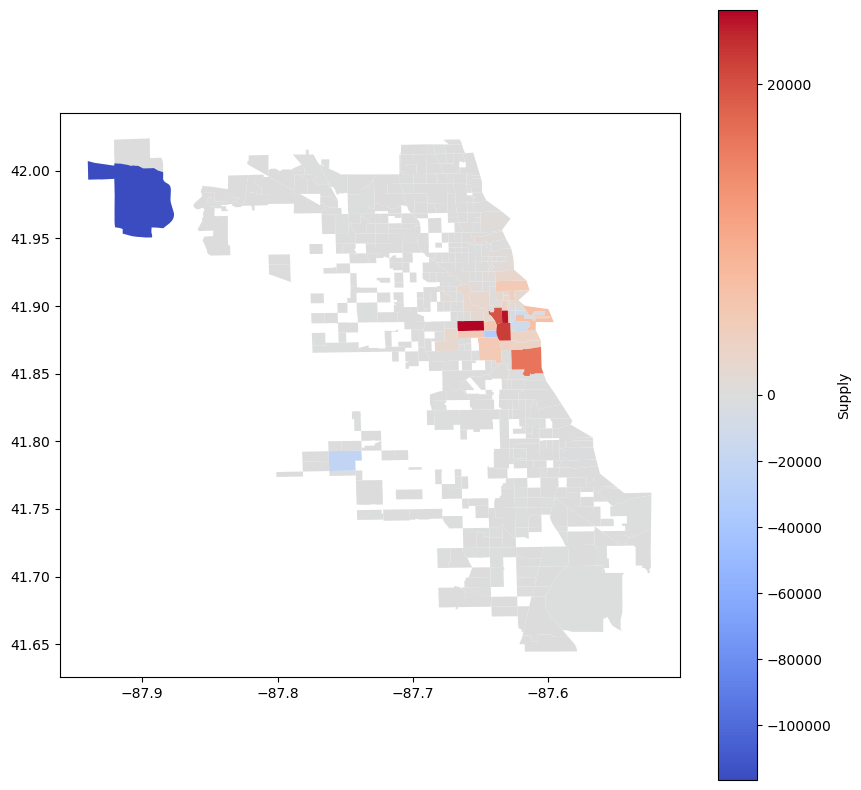

In [43]:
plot_gpd(taxi_by_census_tract_gpd, "trip_amount_balance", "Supply", True)

<AxesSubplot: >

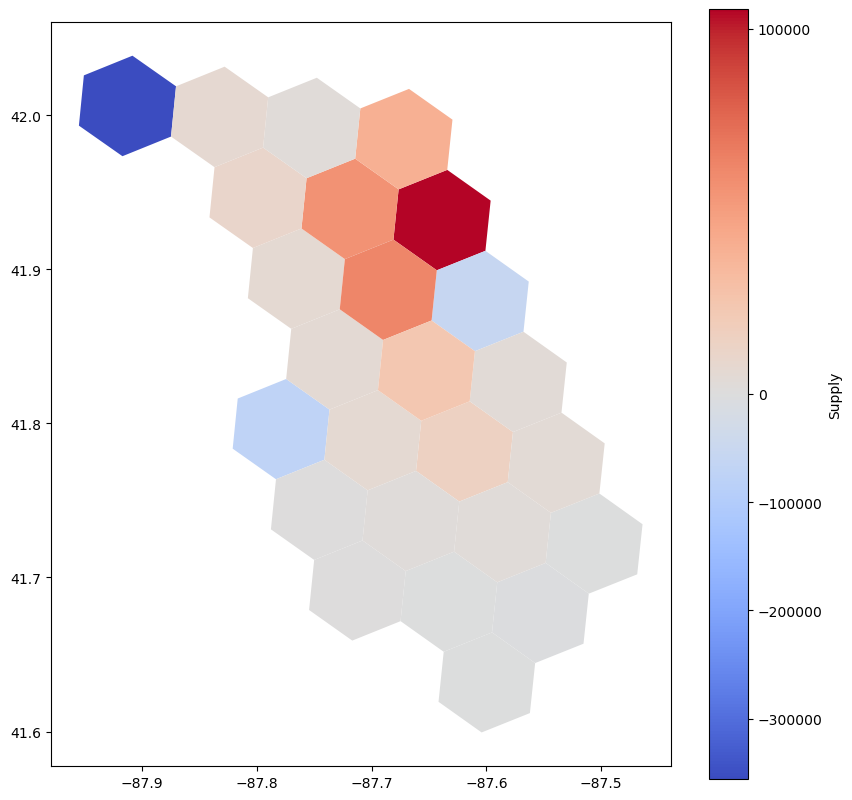

In [44]:
plot_gpd(taxi_h3_6_gpd, "trip_amount_balance", "Supply", True)

<AxesSubplot: >

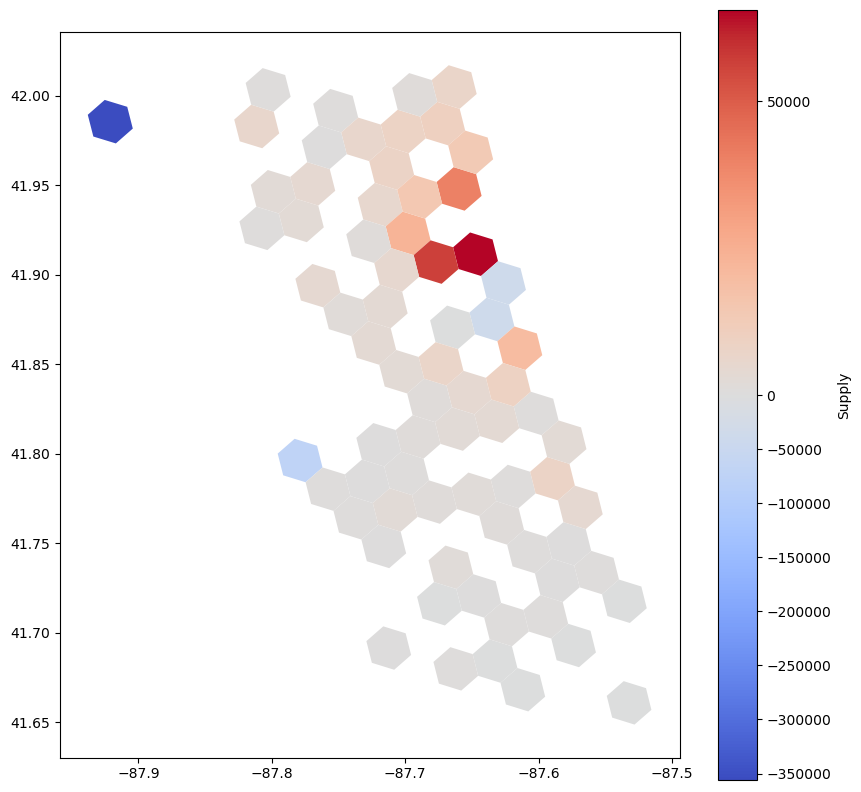

In [45]:
plot_gpd(taxi_h3_7_gpd, "trip_amount_balance", "Supply", True)

<AxesSubplot: >

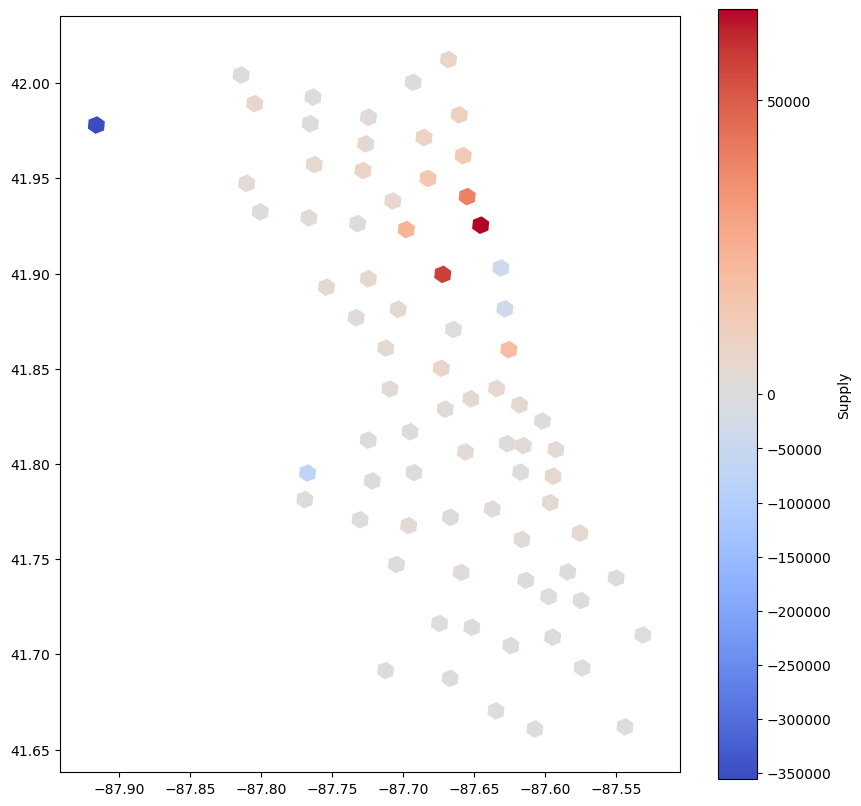

In [46]:
plot_gpd(taxi_h3_8_gpd, "trip_amount_balance", "Supply", True)

We can see that the outer city district (where all outer city trip starts are likely lumped into) is a prime spot for starting a trip, but much fewer end there. The inner city seems to be the spot where most people from out of the city and the outer city want to go to, which is why it has a lot more trip ends than trip starts.

### Top 5 Community Areas

Next up we want to identify the top five community areas for closer inspection. We do this by simply adding trip starts and trip ends together and picking the top five.

In [69]:
cmap = ListedColormap(["blue", "orange", "green", "red", "purple"])

In [70]:
# top_community_areas
taxi_by_community_area_top_list = list(taxi_by_community_area.sort_values(by='trip_amount_pickup', key=taxi_by_community_area['trip_amount_dropoff'].add, ascending=False).groupby('community_area').head(5).head(5)["community_area"])
taxi_by_community_area_top_list

[8.0, 32.0, 28.0, 76.0, 6.0]

In [71]:
rankings = {taxi_by_community_area_top_list[0]: "First", taxi_by_community_area_top_list[1]: "Second", taxi_by_community_area_top_list[2]: "Third", taxi_by_community_area_top_list[3]: "Fourth", taxi_by_community_area_top_list[4]: "Fifth"}

taxi_by_community_area_gpd["mark"] = taxi_by_community_area_gpd["community_area"].apply(lambda x: rankings.get(x) if x in rankings else None)

<AxesSubplot: >

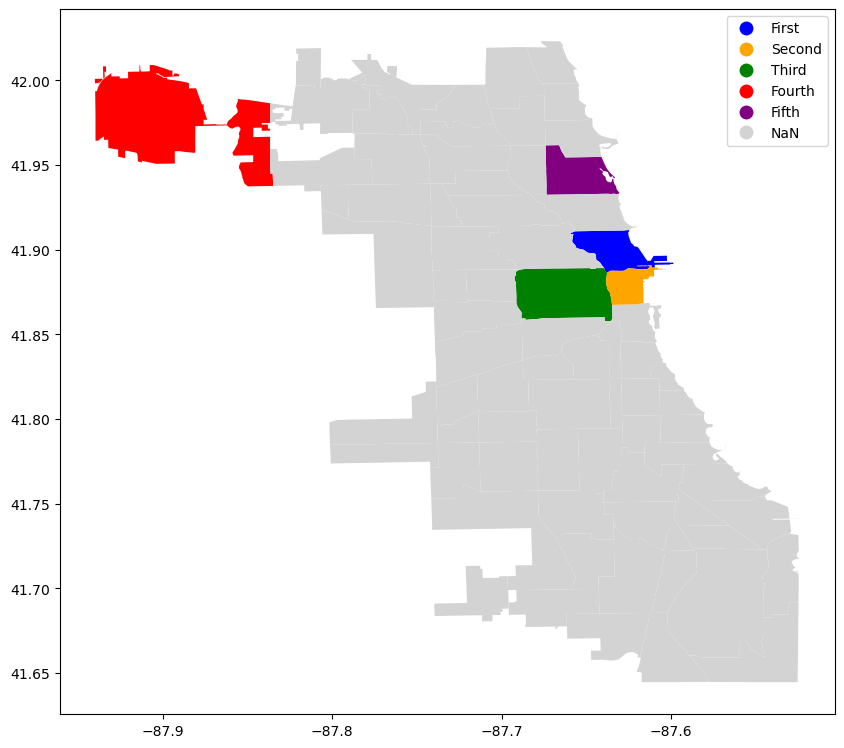

In [72]:
taxi_by_community_area_gpd.plot(legend=True, column="mark", figsize=(10, 10), categories=["First", "Second", "Third", "Fourth", "Fifth"], cmap=cmap, missing_kwds = dict(color = "lightgrey",))

### Comparing top areas with Point-Of-Interest Data 

Looking at our collected point of interests and plotting them together with trip demand, we see that the most frequented regions also align very well with a high concentration of points of interest

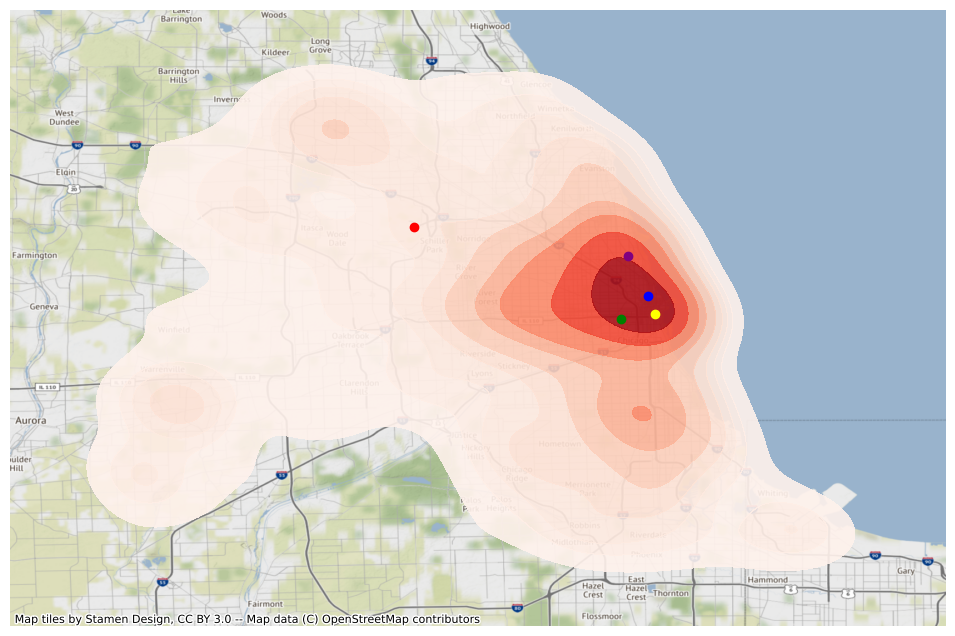

In [104]:
poi = gpd.read_file(f"{file_path}poi.geojson")
f, ax = plt.subplots(ncols=1, figsize=(20, 8))
kde = sns.kdeplot(
    ax=ax,
    x=poi['geometry'].x,
    y= poi['geometry'].y,
    fill=True,
    cmap='Reds',
    alpha=0.9
)
ctx.add_basemap(ax=ax,crs = poi.crs.to_string())
ax.set_axis_off()
coordinate1 = taxi_by_community_area_gpd[taxi_by_community_area_gpd["mark"] == "First"]["geometry"].centroid
coordinate2 = taxi_by_community_area_gpd[taxi_by_community_area_gpd["mark"] == "Second"]["geometry"].centroid
coordinate3 = taxi_by_community_area_gpd[taxi_by_community_area_gpd["mark"] == "Third"]["geometry"].centroid
coordinate4 = taxi_by_community_area_gpd[taxi_by_community_area_gpd["mark"] == "Fourth"]["geometry"].centroid
coordinate5 = taxi_by_community_area_gpd[taxi_by_community_area_gpd["mark"] == "Fifth"]["geometry"].centroid
ax.plot(coordinate1.x, coordinate1.y, marker="o", color="blue")
ax.plot(coordinate2.x, coordinate2.y, marker="o", color="yellow")
ax.plot(coordinate3.x, coordinate3.y, marker="o", color="green")
ax.plot(coordinate4.x, coordinate4.y, marker="o", color="red")
ax.plot(coordinate5.x, coordinate5.y, marker="o", color="purple")

plt.show()

### Top 5 H3-6 Hexagons

We do the same thing we did with the community areas here, just for h3 in resolution 6

In [70]:
# top_h3-6 hexagons
taxi_by_h3_6_top_list = list(taxi_by_h3_6.sort_values(by='trip_amount_pickup', key=taxi_by_h3_6['trip_amount_dropoff'].add, ascending=False).groupby('h3_6_pickup').head(5).head(5)["h3_6_pickup"])
taxi_by_h3_6_top_list

['862664c1fffffff',
 '862664cafffffff',
 '862759347ffffff',
 '862664c17ffffff',
 '862664d8fffffff']

In [71]:
rankings_h3_6 = {taxi_by_h3_6_top_list[0]: "First", taxi_by_h3_6_top_list[1]: "Second", taxi_by_h3_6_top_list[2]: "Third", taxi_by_h3_6_top_list[3]: "Fourth", taxi_by_h3_6_top_list[4]: "Fifth"}

taxi_h3_6_gpd["mark"] = taxi_h3_6_gpd.index.map(lambda x: rankings_h3_6.get(x) if x in rankings_h3_6 else None)

<AxesSubplot: >

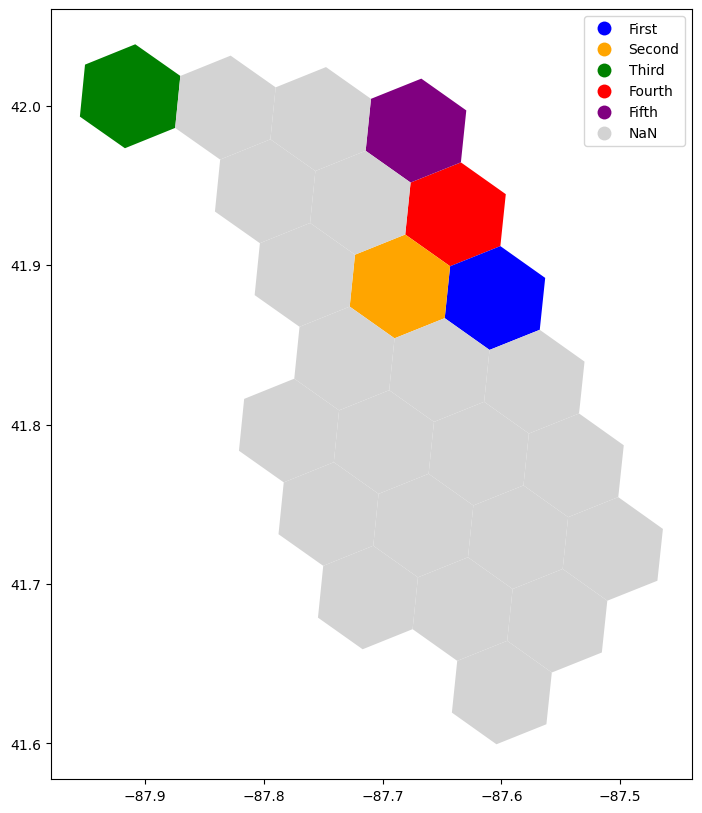

In [72]:
taxi_h3_6_gpd.plot(legend=True, column="mark", figsize=(10, 10), categories=["First", "Second", "Third", "Fourth", "Fifth"], cmap=cmap, missing_kwds = dict(color = "lightgrey",))

### Top 5 H3-8 Hexagons

And the same again for h3 resolution 8

In [73]:
# top_h3-8 hexagons
taxi_by_h3_8_top_list = list(taxi_by_h3_8.sort_values(by='trip_amount_pickup', key=taxi_by_h3_8['trip_amount_dropoff'].add, ascending=False).groupby('h3_8_pickup').head(5).head(5)["h3_8_pickup"])
taxi_by_h3_8_top_list

['882664c1edfffff',
 '882664c1a9fffff',
 '882664ca91fffff',
 '8827593433fffff',
 '882664c163fffff']

In [74]:
rankings_h3_8 = {taxi_by_h3_8_top_list[0]: "First", taxi_by_h3_8_top_list[1]: "Second", taxi_by_h3_8_top_list[2]: "Third", taxi_by_h3_8_top_list[3]: "Fourth", taxi_by_h3_8_top_list[4]: "Fifth"}

taxi_h3_8_gpd["mark"] = taxi_h3_8_gpd.index.map(lambda x: rankings_h3_8.get(x) if x in rankings_h3_8 else None)

<AxesSubplot: >

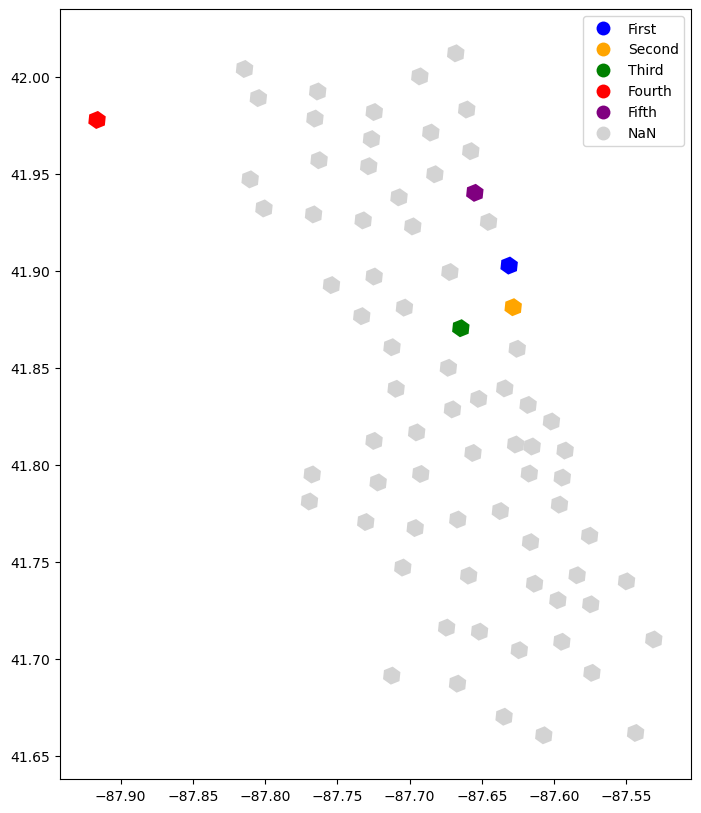

In [75]:
taxi_h3_8_gpd.plot(legend=True, column="mark", figsize=(10, 10), categories=["First", "Second", "Third", "Fourth", "Fifth"], cmap=cmap, missing_kwds = dict(color = "lightgrey",))

## Spatio-Temporal Analysis

Finally, we analyze the data in a spatio-temporal way, so geographic and temporal at the same time. We start by loading in the prepared datasets.

In [76]:
taxi_by_census_tract_1H = pd.read_csv(f"{file_path}taxi_by_census_tract_1H.csv")
taxi_by_community_area_1H = pd.read_csv(f"{file_path}taxi_by_community_area_1H.csv")
taxi_by_h3_6_1H = pd.read_csv(f"{file_path}taxi_by_h3_6_1H.csv")
taxi_by_h3_7_1H = pd.read_csv(f"{file_path}taxi_by_h3_7_1H.csv")
taxi_by_h3_8_1H = pd.read_csv(f"{file_path}taxi_by_h3_8_1H.csv")
taxi_by_census_tract_4H = pd.read_csv(f"{file_path}taxi_by_census_tract_4H.csv")
taxi_by_community_area_4H = pd.read_csv(f"{file_path}taxi_by_community_area_4H.csv")
taxi_by_h3_6_4H = pd.read_csv(f"{file_path}taxi_by_h3_6_4H.csv")
taxi_by_h3_7_4H = pd.read_csv(f"{file_path}taxi_by_h3_7_4H.csv")
taxi_by_h3_8_4H = pd.read_csv(f"{file_path}taxi_by_h3_8_4H.csv")
taxi_by_census_tract_24H = pd.read_csv(f"{file_path}taxi_by_census_tract_24H.csv")
taxi_by_community_area_24H = pd.read_csv(f"{file_path}taxi_by_community_area_24H.csv")
taxi_by_h3_6_24H = pd.read_csv(f"{file_path}taxi_by_h3_6_24H.csv")
taxi_by_h3_7_24H = pd.read_csv(f"{file_path}taxi_by_h3_7_24H.csv")
taxi_by_h3_8_24H = pd.read_csv(f"{file_path}taxi_by_h3_8_24H.csv")

We add all these dataframes to lists for convenience

In [77]:
dataframes_1H = [taxi_by_census_tract_1H, taxi_by_community_area_1H, taxi_by_h3_6_1H, taxi_by_h3_7_1H, taxi_by_h3_8_1H]
dataframes_4H = [taxi_by_census_tract_4H, taxi_by_community_area_4H, taxi_by_h3_6_4H, taxi_by_h3_7_4H, taxi_by_h3_8_4H]
dataframes_24H = [taxi_by_census_tract_24H, taxi_by_community_area_24H, taxi_by_h3_6_24H, taxi_by_h3_7_24H, taxi_by_h3_8_24H]

Then we extract hours, days, weekdays and weeks from the timestamp column and put them into separate columns

In [78]:
def add_day(dataframelist):
    for dataframe in dataframelist:
        dataframe["day"] = pd.to_datetime(dataframe["trip_start_timestamp"]).map(lambda x: x.timetuple().tm_yday)
        dataframe["weekday"] = pd.to_datetime(dataframe["trip_start_timestamp"]).map(lambda x: x.timetuple().tm_wday)
        dataframe["week"] = pd.to_datetime(dataframe["trip_start_timestamp"]).map(lambda x: datetime.fromtimestamp(mktime(x.timetuple())).isocalendar().week)
        
def add_hour_and_absolute_hour(dataframelist):
    for dataframe in dataframelist:
        dataframe["hour"] = pd.to_datetime(dataframe["trip_start_timestamp"]).map(lambda x: x.hour)
        dataframe["abs_hour"] = pd.to_datetime(dataframe["trip_start_timestamp"]).map(lambda x: x.hour * x.timetuple().tm_yday)

In [79]:
add_day(dataframes_1H)
add_hour_and_absolute_hour(dataframes_1H)
add_day(dataframes_4H)
add_hour_and_absolute_hour(dataframes_4H)
add_day(dataframes_24H)
taxi_by_census_tract_4H.head(5)

trip_start_timestamp  census_tract  trip_amount_pickup  mean_trip_seconds  \
0  2021-01-01 08:00:00  1.703132e+10                 1.0             1445.0   
1  2021-01-01 08:00:00  1.703198e+10                 1.0               47.0   
2  2021-01-01 12:00:00  1.703108e+10                 2.0              600.0   
3  2021-01-01 12:00:00  1.703108e+10                 1.0              442.0   
4  2021-01-01 12:00:00  1.703128e+10                 6.0              510.0   

   mean_trip_miles  mean_trip_total  start_temp  start_precip  \
0        17.960000           55.620    0.370000           1.0   
1         0.070000            3.250    0.140000           0.0   
2         1.950000            8.875    1.330000           1.0   
3         1.080000            9.250    0.900000           1.0   
4         1.483333            7.750    1.043333           1.0   

   start_windspeed  end_temp  end_precip  end_windspeed  trip_amount_dropoff  \
0        10.700000  0.370000         1.0      10.700000                  0.0   
1        10.740000  0.140000         0.0      10.740000                  3.0   
2        11.150000  1.330000         1.0      11.790000                  0.0   
3        11.180000  0.900000         1.0      11.180000                  0.0   
4        11.383333  1.043333         1.0      11.383333                  8.0   

   trip_amount_balance                                           geometry  \
0                 -1.0  MULTIPOLYGON (((-87.61343799999288 41.88788700...   
1                  2.0  MULTIPOLYGON (((-87.92062799997296 42.00453199...   
2                 -2.0  MULTIPOLYGON (((-87.61664600002327 41.89679299...   
3                 -1.0  MULTIPOLYGON (((-87.62960699996654 41.89003999...   
4                  2.0  MULTIPOLYGON (((-87.64592199996342 41.88178900...   

   day  weekday  week  hour  abs_hour  
0    1        4    53     8         8  
1    1        4    53     8         8  
2    1        4    53    12        12  
3    1        4    53    12        12  
4    1        4    53    12        12

### By Community Area

To start off, we analyze the spatio-temporal dimension using community areas. To not make it too confusing, we choose only the top 5 community areas for this.

In [80]:
taxi_by_community_area_24H_top = taxi_by_community_area_24H[taxi_by_community_area_24H['community_area'].isin(taxi_by_community_area_top_list)]
taxi_by_community_area_1H_top = taxi_by_community_area_1H[taxi_by_community_area_1H['community_area'].isin(taxi_by_community_area_top_list)]
taxi_by_community_area_24H_top["ranking"] = taxi_by_community_area_24H_top["community_area"].apply(lambda x: rankings.get(x))
taxi_by_community_area_1H_top["ranking"] = taxi_by_community_area_1H_top["community_area"].apply(lambda x: rankings.get(x))
taxi_by_community_area_24H_top.head(5)

C:\Users\Onno Peters\AppData\Local\Temp\ipykernel_15340\1257745710.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_by_community_area_24H_top["ranking"] = taxi_by_community_area_24H_top["community_area"].apply(lambda x: rankings.get(x))
C:\Users\Onno Peters\AppData\Local\Temp\ipykernel_15340\1257745710.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_by_community_area_1H_top["ranking"] = taxi_by_community_area_1H_top["community_area"].apply(lambda x: rankings.get(x))


trip_start_timestamp  community_area  trip_amount_pickup  \
5            2021-01-01             6.0               102.0   
7            2021-01-01             8.0               429.0   
26           2021-01-01            28.0               194.0   
30           2021-01-01            32.0               146.0   
73           2021-01-01            76.0               355.0   

    mean_trip_seconds  mean_trip_miles  mean_trip_total  start_temp  \
5          780.725490         2.958137        14.715882    0.770686   
7          720.384615         2.998578        14.233939    0.855967   
26         867.768041         4.728969        17.696031    0.742887   
30         822.294521         3.961781        17.128082    0.881849   
73        1383.980282        12.307408        44.910310    1.254676   

    start_precip  start_windspeed  end_temp  end_precip  end_windspeed  \
5       0.372549        10.248529  0.782745    0.401961      10.243824   
7       0.452214        10.318811  0.879674    0.449883      10.316317   
26      0.551546        10.312423  0.776340    0.530928      10.323763   
30      0.554795        10.609041  0.902877    0.547945      10.609041   
73      0.422535        10.241718  1.304958    0.383099      10.255239   

    trip_amount_dropoff  trip_amount_balance  \
5                 139.0                 37.0   
7                 413.0                -16.0   
26                176.0                -18.0   
30                149.0                  3.0   
73                 80.0               -275.0   

                                             geometry  day  weekday  week  \
5   MULTIPOLYGON (((-87.64102430213292 41.95480280...    1        4    53   
7   MULTIPOLYGON (((-87.62446476694345 41.91156699...    1        4    53   
26  MULTIPOLYGON (((-87.6375883858287 41.886234136...    1        4    53   
30  MULTIPOLYGON (((-87.6094858028664 41.889399110...    1        4    53   
73  MULTIPOLYGON (((-87.83658087874365 41.98639611...    1        4    53   

   ranking  
5    Fifth  
7    First  
26   Third  
30  Second  
73  Fourth

#### Amount of trip starts

A short visualization from above to again show what the top 5 community areas are. Keep in mind the green one is likely all out-of-city trips together and not actually the district.

<AxesSubplot: >

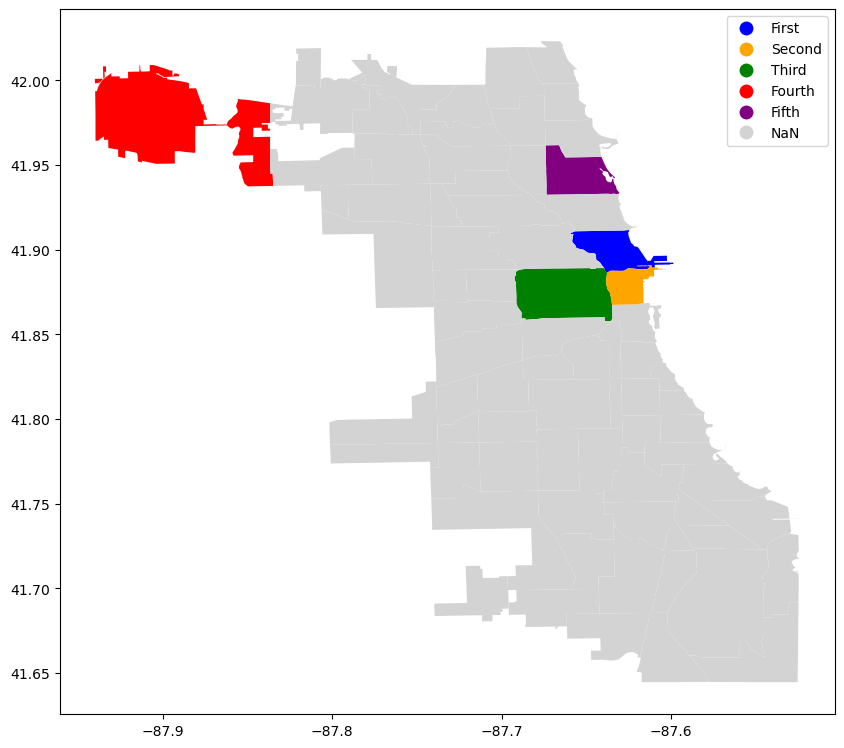

In [81]:
taxi_by_community_area_gpd.plot(legend=True, column="mark", figsize=(10, 10), categories=["First", "Second", "Third", "Fourth", "Fifth"], cmap=cmap, missing_kwds = dict(color = "lightgrey",))

We can see the peak in the afternoon for pretty much all areas, but especially for the inner city, while the out-of-city area has a peak more in the evening.

<AxesSubplot: xlabel='hour', ylabel='trip_amount_pickup'>

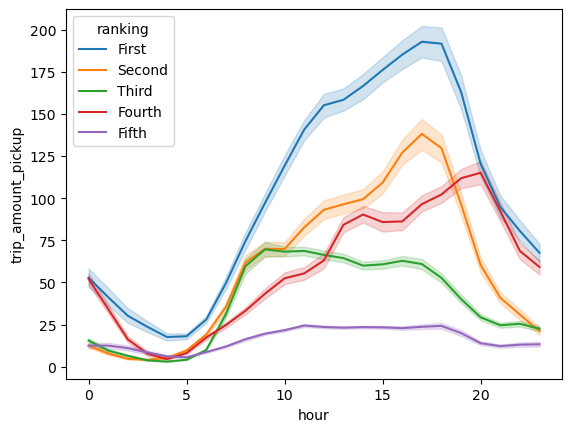

In [82]:
sns.lineplot(data=taxi_by_community_area_1H_top, x="hour", y="trip_amount_pickup", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

The inner-city districts are highest in the week and drop off at the weekend, while the out-of-city district rises at the weekend.

<AxesSubplot: xlabel='weekday', ylabel='trip_amount_pickup'>

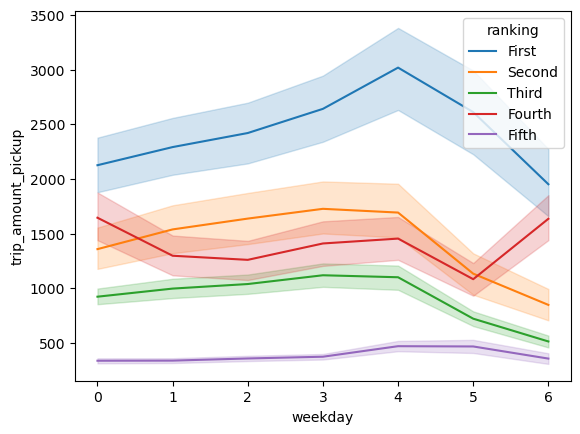

In [83]:
sns.lineplot(data=taxi_by_community_area_24H_top, x="weekday", y="trip_amount_pickup", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

The distribution over the year follows the trend seen at the top of this notebook with more trips later in the year, especially for the inner city areas. This graphic is confusing, but the one below using weeks instead of days makes it more clear.

<AxesSubplot: xlabel='day', ylabel='trip_amount_pickup'>

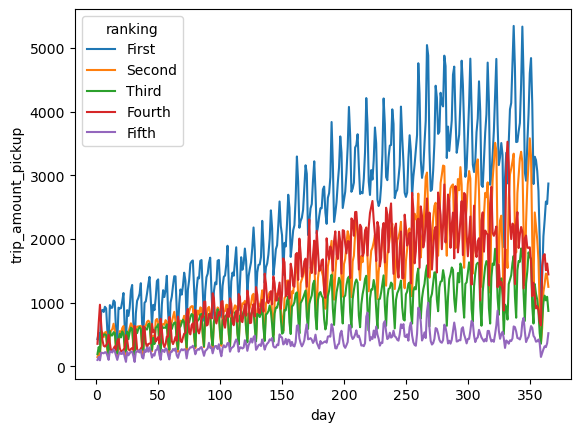

In [84]:
sns.lineplot(data=taxi_by_community_area_24H_top, x="day", y="trip_amount_pickup", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='week', ylabel='trip_amount_pickup'>

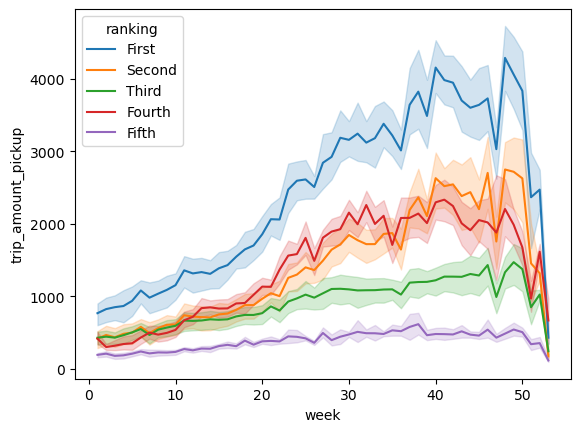

In [85]:
sns.lineplot(data=taxi_by_community_area_24H_top, x="week", y="trip_amount_pickup", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

#### Amount of trip ends

Trip ends follow similar trends to trip starts, except for the out-of-city area, which seems to have much less ends compared to starts.

<AxesSubplot: xlabel='hour', ylabel='trip_amount_dropoff'>

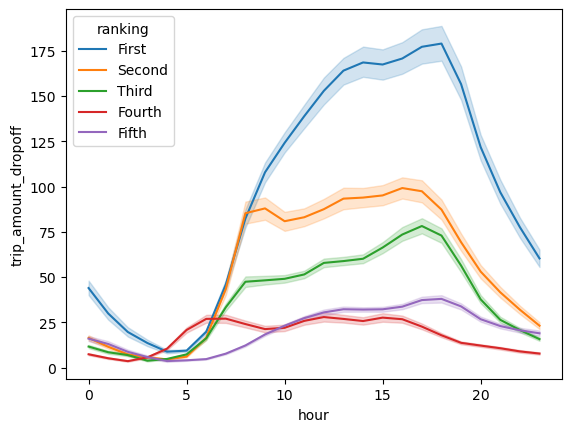

In [86]:
sns.lineplot(data=taxi_by_community_area_1H_top, x="hour", y="trip_amount_dropoff", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='weekday', ylabel='trip_amount_dropoff'>

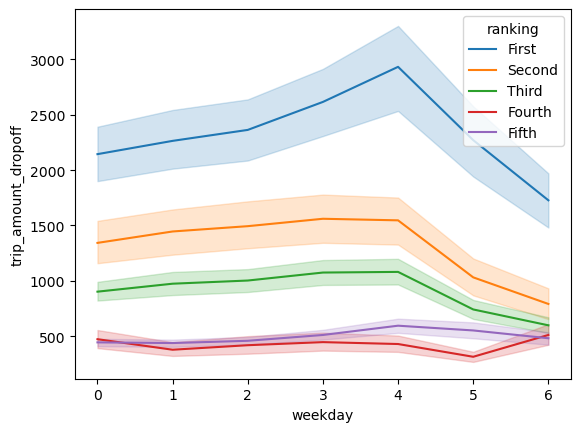

In [87]:
sns.lineplot(data=taxi_by_community_area_24H_top, x="weekday", y="trip_amount_dropoff", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='day', ylabel='trip_amount_dropoff'>

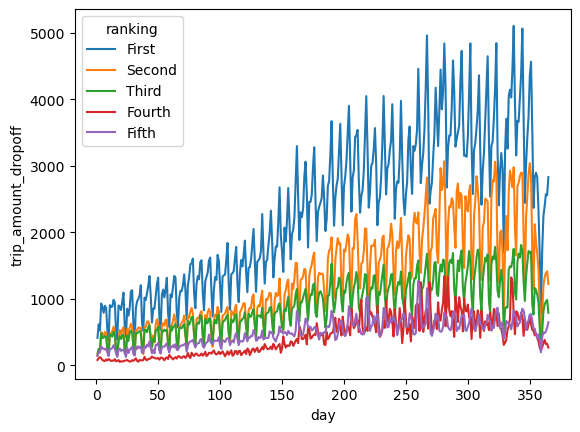

In [88]:
sns.lineplot(data=taxi_by_community_area_24H_top, x="day", y="trip_amount_dropoff", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='week', ylabel='trip_amount_dropoff'>

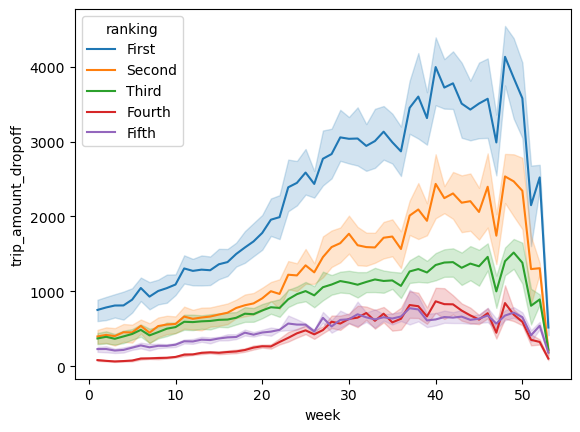

In [89]:
sns.lineplot(data=taxi_by_community_area_24H_top, x="week", y="trip_amount_dropoff", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

#### Amount of trip ends minus starts (balance)

The fact that the out-of-city area has much less ends than starts can easily be seen when visualizing the balance. This is espcecially true around the evening, when people want to go to the inner city the most.

<AxesSubplot: xlabel='hour', ylabel='trip_amount_balance'>

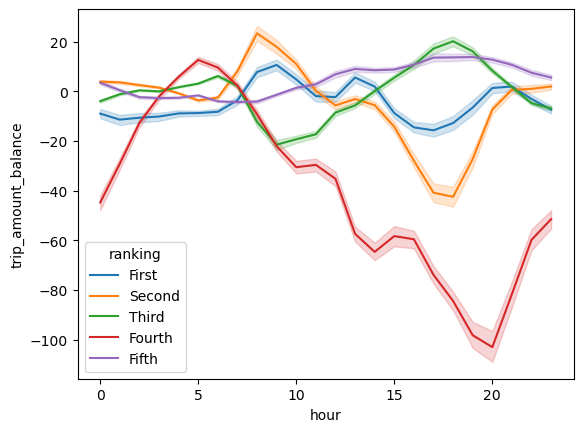

In [90]:
sns.lineplot(data=taxi_by_community_area_1H_top, x="hour", y="trip_amount_balance", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

It is also true for the entire week, but especially the weekend. Interestingly the most popular inner-city area also has a lot less ends than starts on the weekend.

<AxesSubplot: xlabel='weekday', ylabel='trip_amount_balance'>

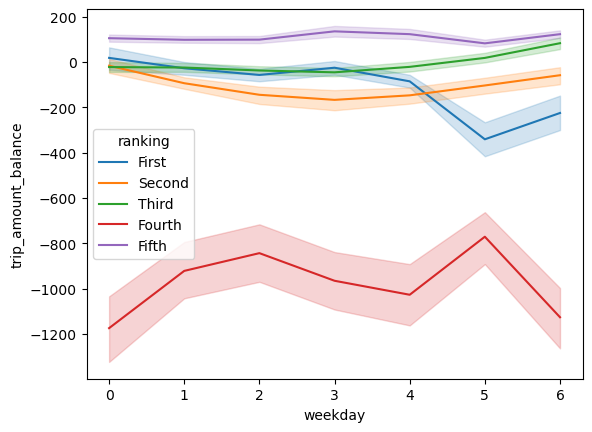

In [91]:
sns.lineplot(data=taxi_by_community_area_24H_top, x="weekday", y="trip_amount_balance", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

Also seems to be true for the entire week

<AxesSubplot: xlabel='day', ylabel='trip_amount_balance'>

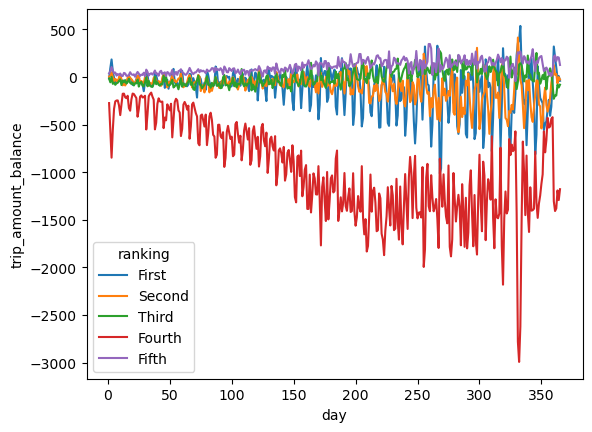

In [92]:
sns.lineplot(data=taxi_by_community_area_24H_top, x="day", y="trip_amount_balance", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='week', ylabel='trip_amount_balance'>

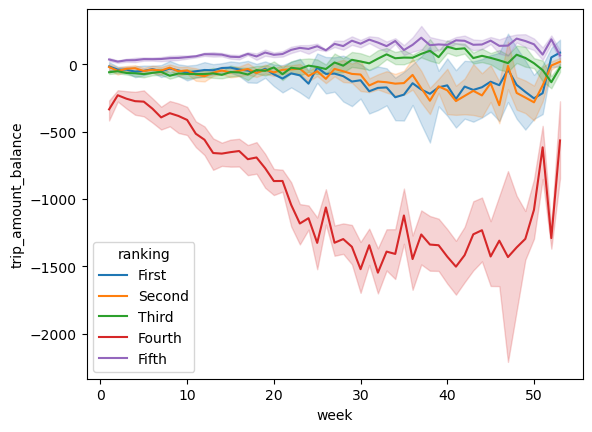

In [93]:
sns.lineplot(data=taxi_by_community_area_24H_top, x="week", y="trip_amount_balance", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

### By H3 Resolution 6

In [94]:
taxi_by_h3_6_24H_top = taxi_by_h3_6_24H[taxi_by_h3_6_24H['h3_6_pickup'].isin(taxi_by_h3_6_top_list)]
taxi_by_h3_6_1H_top = taxi_by_h3_6_1H[taxi_by_h3_6_1H['h3_6_pickup'].isin(taxi_by_h3_6_top_list)]
taxi_by_h3_6_24H_top["ranking"] = taxi_by_h3_6_24H_top["h3_6_pickup"].apply(lambda x: rankings_h3_6.get(x))
taxi_by_h3_6_1H_top["ranking"] = taxi_by_h3_6_1H_top["h3_6_pickup"].apply(lambda x: rankings_h3_6.get(x))
taxi_by_h3_6_24H_top.head(5)

C:\Users\Onno Peters\AppData\Local\Temp\ipykernel_15340\3823636710.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_by_h3_6_24H_top["ranking"] = taxi_by_h3_6_24H_top["h3_6_pickup"].apply(lambda x: rankings_h3_6.get(x))
C:\Users\Onno Peters\AppData\Local\Temp\ipykernel_15340\3823636710.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_by_h3_6_1H_top["ranking"] = taxi_by_h3_6_1H_top["h3_6_pickup"].apply(lambda x: rankings_h3_6.get(x))


trip_start_timestamp      h3_6_pickup  trip_amount_pickup  \
7            2021-01-01  862664c17ffffff               148.0   
8            2021-01-01  862664c1fffffff               636.0   
12           2021-01-01  862664cafffffff               264.0   
21           2021-01-01  862664d8fffffff               300.0   
23           2021-01-01  862759347ffffff               355.0   

    mean_trip_seconds  mean_trip_miles  mean_trip_total  start_temp  \
7          835.358108         3.664189        16.123041    0.751689   
8          771.772013         3.509921        15.502327    0.846871   
12         894.151515         4.614394        17.807462    0.649962   
21         894.696667         3.690500        14.961767    0.649833   
23        1383.980282        12.307408        44.910310    1.254676   

    start_precip  start_windspeed  end_temp  end_precip  end_windspeed  \
7       0.371622        10.191351  0.777770    0.405405      10.195338   
8       0.487421        10.389025  0.874638    0.479560      10.391258   
12      0.488636        10.146856  0.685076    0.481061      10.173182   
21      0.413333        10.238267  0.682667    0.423333      10.255200   
23      0.422535        10.241718  1.304958    0.383099      10.255239   

    trip_amount_dropoff  trip_amount_balance  day  weekday  week ranking  
7                 217.0                 69.0    1        4    53  Fourth  
8                 633.0                 -3.0    1        4    53   First  
12                280.0                 16.0    1        4    53  Second  
21                334.0                 34.0    1        4    53   Fifth  
23                 80.0               -275.0    1        4    53   Third

<AxesSubplot: >

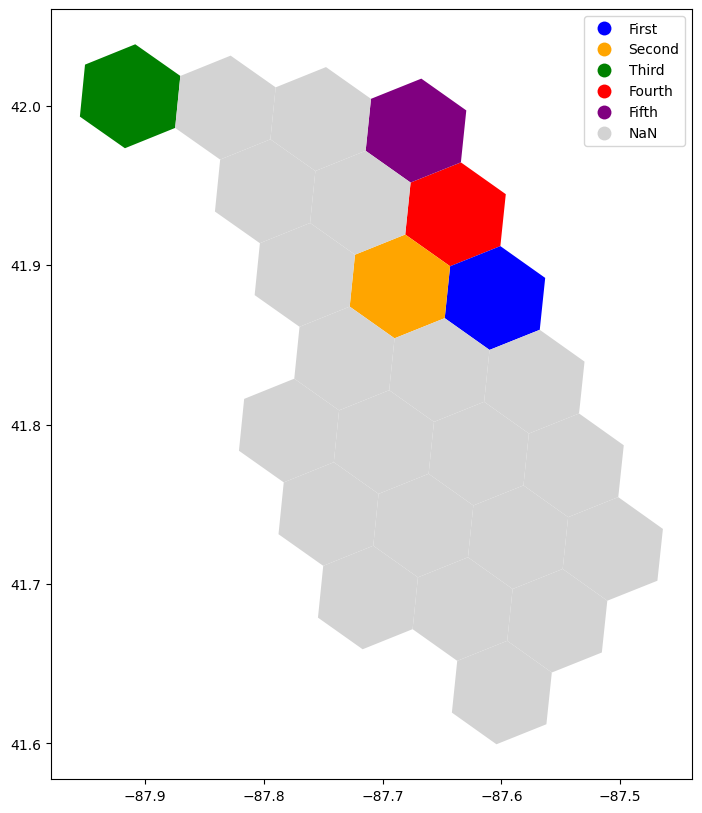

In [95]:
taxi_h3_6_gpd.plot(legend=True, column="mark", figsize=(10, 10), categories=["First", "Second", "Third", "Fourth", "Fifth"], cmap=cmap, missing_kwds = dict(color = "lightgrey",))

#### Amount of trip starts

We observe similar trends to the community area section here, but even more pronounced, as this h3 resolution aggregates the entire inner city into a hexagon.

<AxesSubplot: xlabel='hour', ylabel='trip_amount_pickup'>

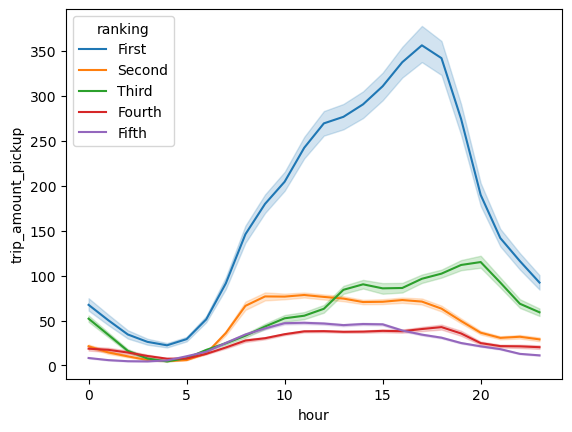

In [96]:
sns.lineplot(data=taxi_by_h3_6_1H_top, x="hour", y="trip_amount_pickup", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='weekday', ylabel='trip_amount_pickup'>

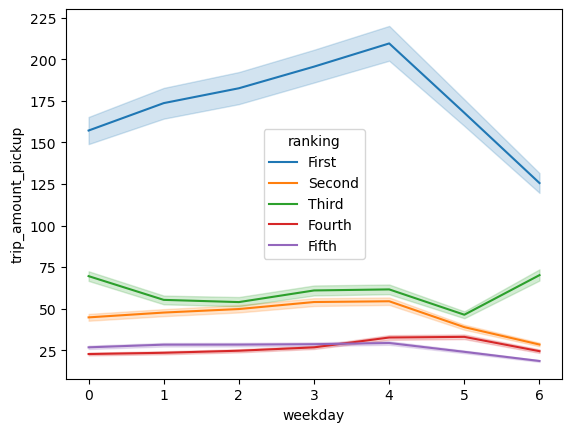

In [97]:
sns.lineplot(data=taxi_by_h3_6_1H_top, x="weekday", y="trip_amount_pickup", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='day', ylabel='trip_amount_pickup'>

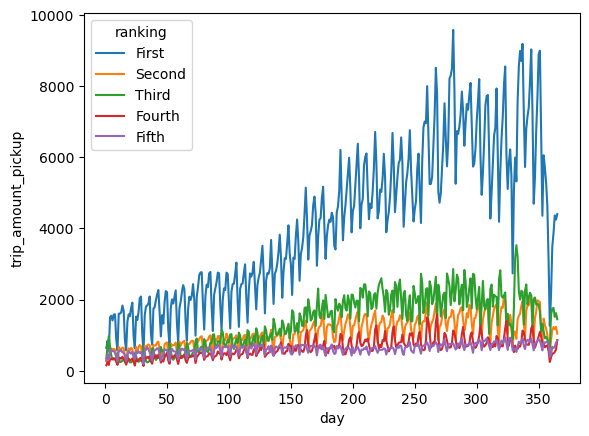

In [98]:
sns.lineplot(data=taxi_by_h3_6_24H_top, x="day", y="trip_amount_pickup", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='week', ylabel='trip_amount_pickup'>

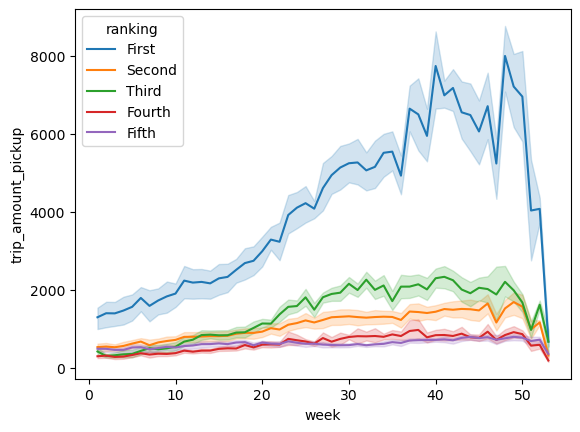

In [99]:
sns.lineplot(data=taxi_by_h3_6_24H_top, x="week", y="trip_amount_pickup", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

#### Amount of trip ends

<AxesSubplot: xlabel='hour', ylabel='trip_amount_dropoff'>

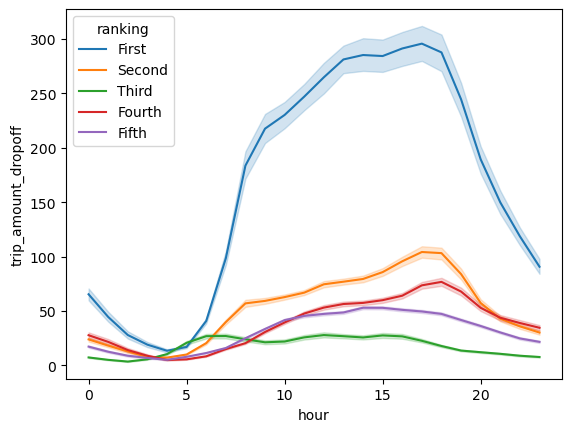

In [100]:
sns.lineplot(data=taxi_by_h3_6_1H_top, x="hour", y="trip_amount_dropoff", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='weekday', ylabel='trip_amount_dropoff'>

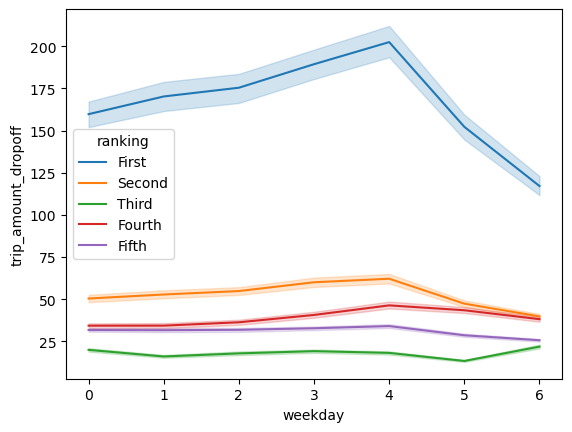

In [101]:
sns.lineplot(data=taxi_by_h3_6_1H_top, x="weekday", y="trip_amount_dropoff", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='day', ylabel='trip_amount_dropoff'>

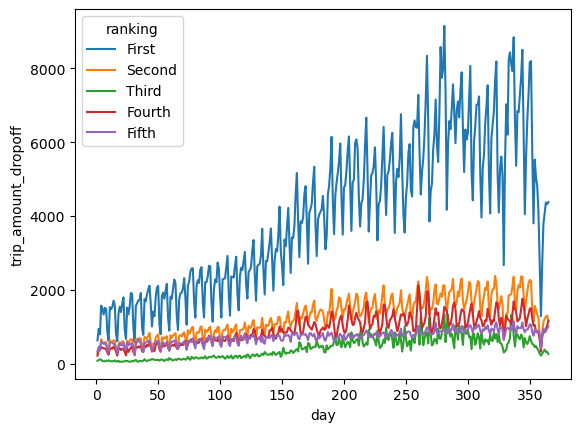

In [102]:
sns.lineplot(data=taxi_by_h3_6_24H_top, x="day", y="trip_amount_dropoff", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='week', ylabel='trip_amount_dropoff'>

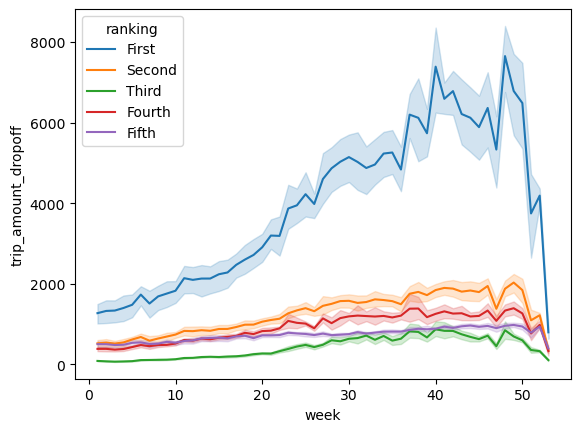

In [103]:
sns.lineplot(data=taxi_by_h3_6_24H_top, x="week", y="trip_amount_dropoff", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

#### Amount of trip ends minus starts (balance)

<AxesSubplot: xlabel='hour', ylabel='trip_amount_balance'>

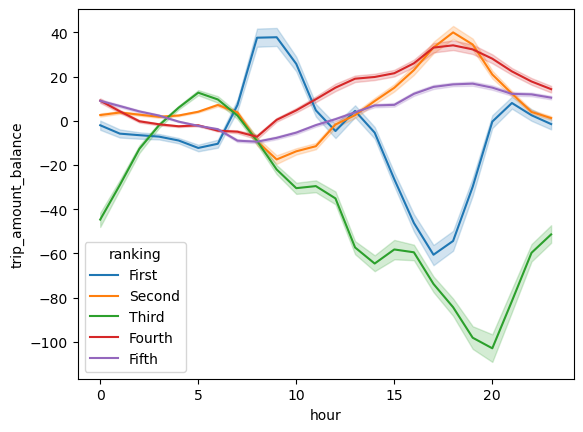

In [104]:
sns.lineplot(data=taxi_by_h3_6_1H_top, x="hour", y="trip_amount_balance", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='weekday', ylabel='trip_amount_balance'>

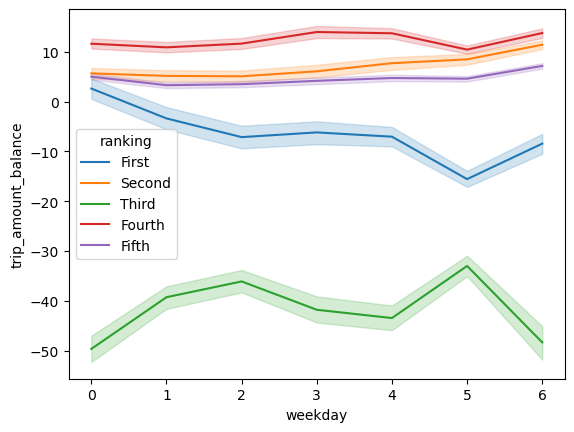

In [105]:
sns.lineplot(data=taxi_by_h3_6_1H_top, x="weekday", y="trip_amount_balance", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='day', ylabel='trip_amount_balance'>

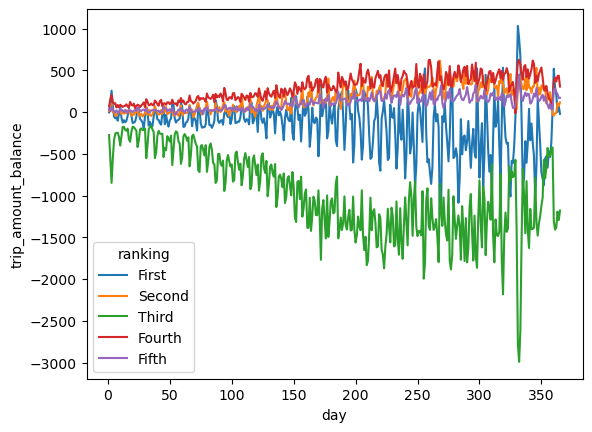

In [106]:
sns.lineplot(data=taxi_by_h3_6_24H_top, x="day", y="trip_amount_balance", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='week', ylabel='trip_amount_balance'>

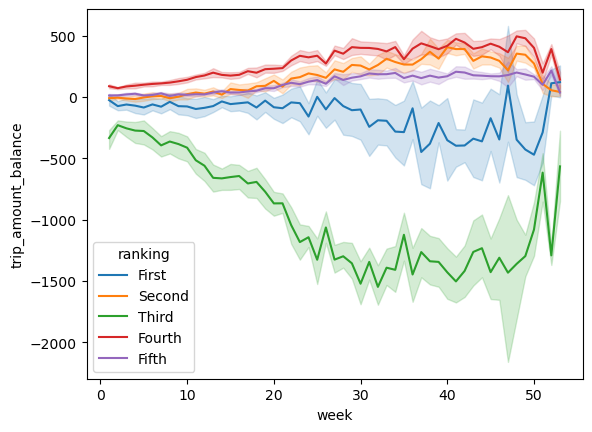

In [107]:
sns.lineplot(data=taxi_by_h3_6_24H_top, x="week", y="trip_amount_balance", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

### By H3 Resolution 8

In [108]:
taxi_by_h3_8_24H_top = taxi_by_h3_8_24H[taxi_by_h3_8_24H['h3_8_pickup'].isin(taxi_by_h3_8_top_list)]
taxi_by_h3_8_1H_top = taxi_by_h3_8_1H[taxi_by_h3_8_1H['h3_8_pickup'].isin(taxi_by_h3_8_top_list)]
taxi_by_h3_8_24H_top["ranking"] = taxi_by_h3_8_24H_top["h3_8_pickup"].apply(lambda x: rankings_h3_8.get(x))
taxi_by_h3_8_1H_top["ranking"] = taxi_by_h3_8_1H_top["h3_8_pickup"].apply(lambda x: rankings_h3_8.get(x))
taxi_by_h3_8_24H_top.head(5)

C:\Users\Onno Peters\AppData\Local\Temp\ipykernel_15340\4155734092.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_by_h3_8_24H_top["ranking"] = taxi_by_h3_8_24H_top["h3_8_pickup"].apply(lambda x: rankings_h3_8.get(x))
C:\Users\Onno Peters\AppData\Local\Temp\ipykernel_15340\4155734092.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_by_h3_8_1H_top["ranking"] = taxi_by_h3_8_1H_top["h3_8_pickup"].apply(lambda x: rankings_h3_8.get(x))


trip_start_timestamp      h3_8_pickup  trip_amount_pickup  \
12           2021-01-01  882664c163fffff               102.0   
13           2021-01-01  882664c1a9fffff               146.0   
15           2021-01-01  882664c1edfffff               429.0   
26           2021-01-01  882664ca91fffff               194.0   
73           2021-01-01  8827593433fffff               355.0   

    mean_trip_seconds  mean_trip_miles  mean_trip_total  start_temp  \
12         780.725490         2.958137        14.715882    0.770686   
13         822.294521         3.961781        17.128082    0.881849   
15         720.384615         2.998578        14.233939    0.855967   
26         867.768041         4.728969        17.696031    0.742887   
73        1383.980282        12.307408        44.910310    1.254676   

    start_precip  start_windspeed  end_temp  end_precip  end_windspeed  \
12      0.372549        10.248529  0.782745    0.401961      10.243824   
13      0.554795        10.609041  0.902877    0.547945      10.609041   
15      0.452214        10.318811  0.879674    0.449883      10.316317   
26      0.551546        10.312423  0.776340    0.530928      10.323763   
73      0.422535        10.241718  1.304958    0.383099      10.255239   

    trip_amount_dropoff  trip_amount_balance  day  weekday  week ranking  
12                139.0                 37.0    1        4    53   Fifth  
13                149.0                  3.0    1        4    53  Second  
15                413.0                -16.0    1        4    53   First  
26                176.0                -18.0    1        4    53   Third  
73                 80.0               -275.0    1        4    53  Fourth

<AxesSubplot: >

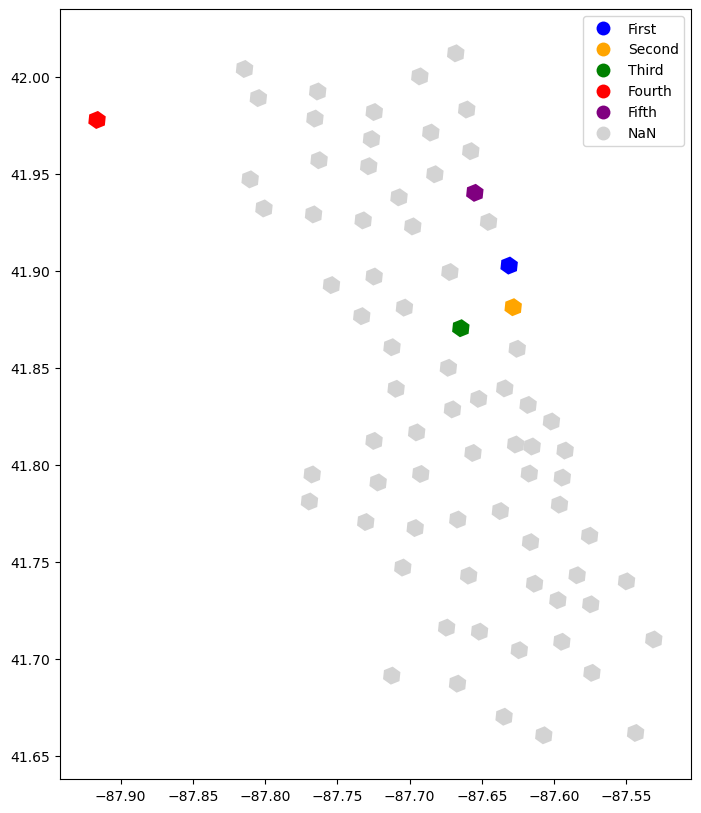

In [109]:
taxi_h3_8_gpd.plot(legend=True, column="mark", figsize=(10, 10), categories=["First", "Second", "Third", "Fourth", "Fifth"], cmap=cmap, missing_kwds = dict(color = "lightgrey",))

#### Amount of trip starts

We again see similar trends to both the community area and the h3 resolution 8 here, but due to the fact that now the inner city is split up, the effects seem less pronounced

<AxesSubplot: xlabel='hour', ylabel='trip_amount_pickup'>

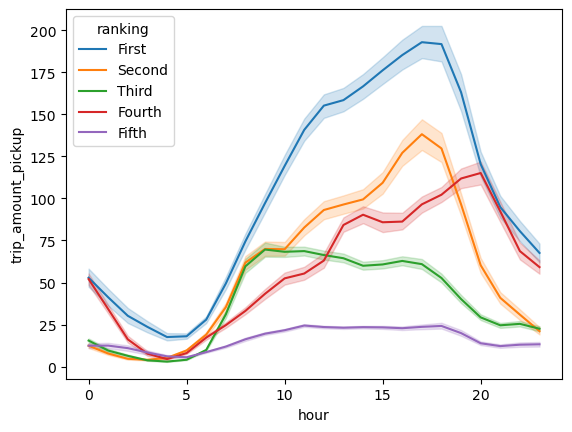

In [110]:
sns.lineplot(data=taxi_by_h3_8_1H_top, x="hour", y="trip_amount_pickup", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='weekday', ylabel='trip_amount_pickup'>

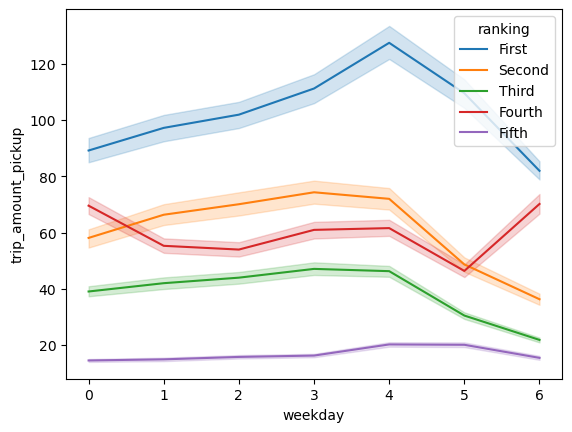

In [111]:
sns.lineplot(data=taxi_by_h3_8_1H_top, x="weekday", y="trip_amount_pickup", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='day', ylabel='trip_amount_pickup'>

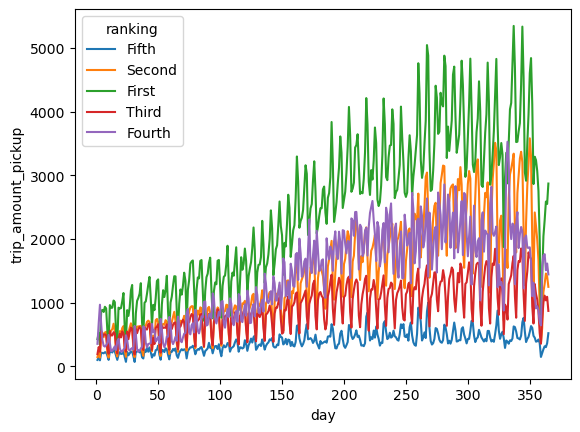

In [112]:
sns.lineplot(data=taxi_by_h3_8_24H_top, x="day", y="trip_amount_pickup", hue="ranking")

<AxesSubplot: xlabel='week', ylabel='trip_amount_pickup'>

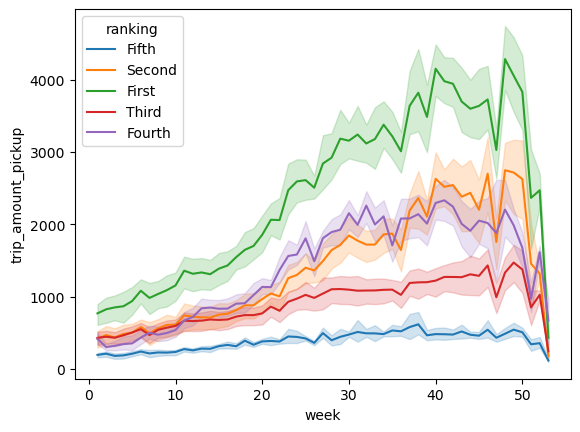

In [113]:
sns.lineplot(data=taxi_by_h3_8_24H_top, x="week", y="trip_amount_pickup", hue="ranking")

#### Amount of trip ends

<AxesSubplot: xlabel='hour', ylabel='trip_amount_dropoff'>

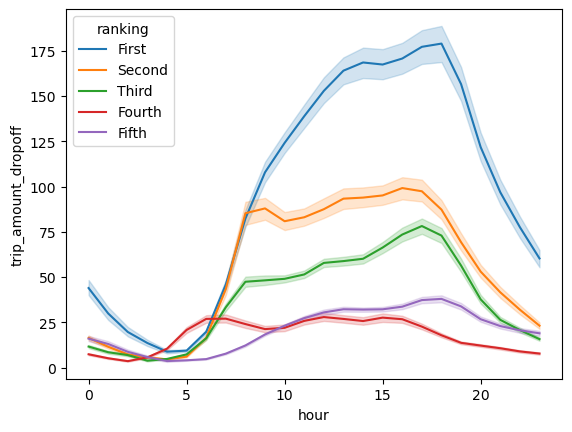

In [114]:
sns.lineplot(data=taxi_by_h3_8_1H_top, x="hour", y="trip_amount_dropoff", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='weekday', ylabel='trip_amount_dropoff'>

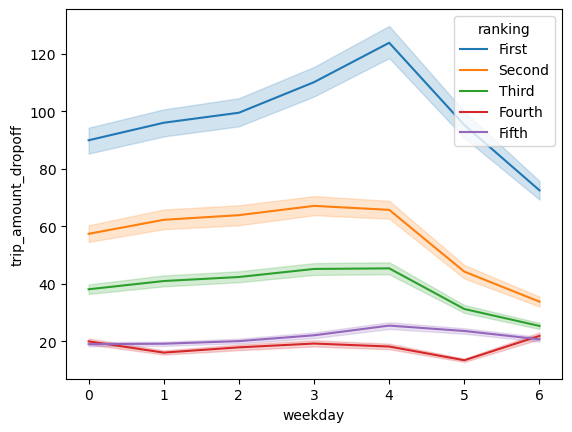

In [115]:
sns.lineplot(data=taxi_by_h3_8_1H_top, x="weekday", y="trip_amount_dropoff", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='day', ylabel='trip_amount_dropoff'>

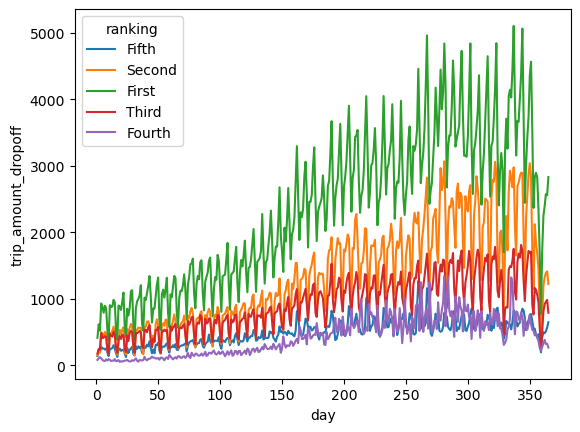

In [116]:
sns.lineplot(data=taxi_by_h3_8_24H_top, x="day", y="trip_amount_dropoff", hue="ranking")

<AxesSubplot: xlabel='week', ylabel='trip_amount_dropoff'>

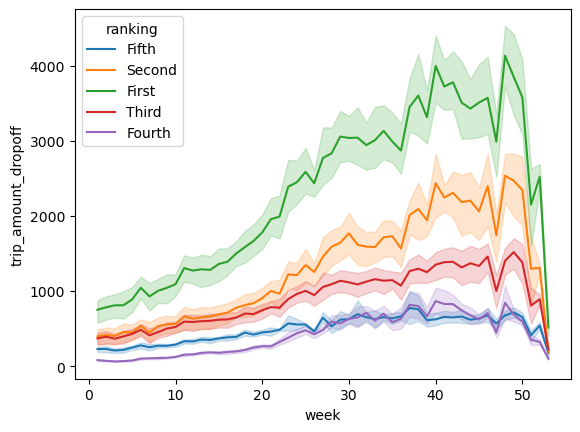

In [117]:
sns.lineplot(data=taxi_by_h3_8_24H_top, x="week", y="trip_amount_dropoff", hue="ranking")

#### Amount of trip ends minus starts (balance)

<AxesSubplot: xlabel='hour', ylabel='trip_amount_balance'>

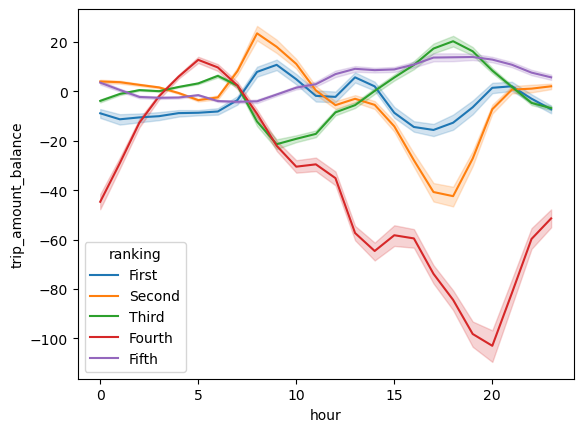

In [118]:
sns.lineplot(data=taxi_by_h3_8_1H_top, x="hour", y="trip_amount_balance", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='weekday', ylabel='trip_amount_balance'>

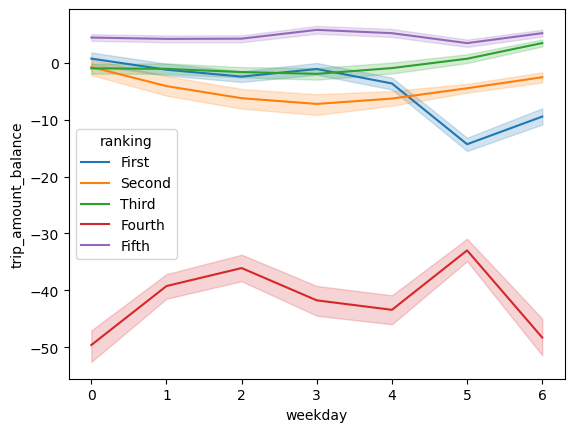

In [119]:
sns.lineplot(data=taxi_by_h3_8_1H_top, x="weekday", y="trip_amount_balance", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='day', ylabel='trip_amount_balance'>

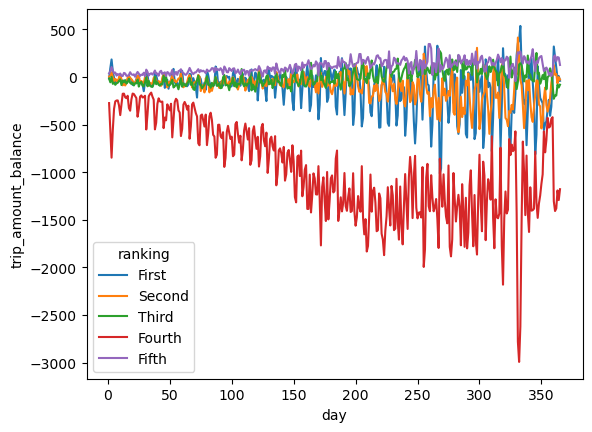

In [120]:
sns.lineplot(data=taxi_by_h3_8_24H_top, x="day", y="trip_amount_balance", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

<AxesSubplot: xlabel='week', ylabel='trip_amount_balance'>

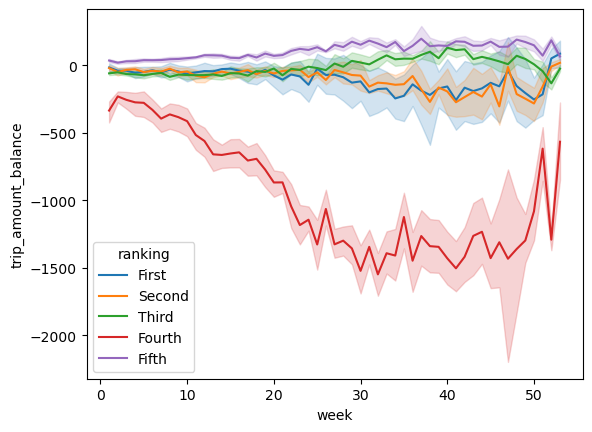

In [121]:
sns.lineplot(data=taxi_by_h3_8_24H_top, x="week", y="trip_amount_balance", hue="ranking", hue_order=["First", "Second", "Third", "Fourth", "Fifth"])

### Geographical trends at different times of day

Finally, we look at this from another perspective. Before we looked at a region and observed different trends over time. Now we look at a time and observe how regions behave.

In [122]:
taxi_by_h3_7_4H_gpd = taxi_by_h3_7_4H.set_index("h3_7_pickup").h3.h3_to_geo_boundary()
taxi_by_h3_7_4H_gpd.head(5)

trip_start_timestamp  trip_amount_pickup  mean_trip_seconds  \
h3_7_pickup                                                                   
872664520ffffff  2021-01-01 00:00:00                 5.0        1200.000000   
87266452dffffff  2021-01-01 00:00:00                 2.0        2107.500000   
872664562ffffff  2021-01-01 00:00:00                 1.0         781.000000   
872664564ffffff  2021-01-01 00:00:00                 1.0        1898.000000   
872664c13ffffff  2021-01-01 00:00:00                 7.0         693.571429   

                 mean_trip_miles  mean_trip_total  start_temp  start_precip  \
h3_7_pickup                                                                   
872664520ffffff         9.440000           42.216   -1.320000           0.0   
87266452dffffff         8.375000           27.875   -1.305000           0.0   
872664562ffffff         5.010000           15.000   -1.330000           0.0   
872664564ffffff         9.600000           30.000   -1.160000           0.0   
872664c13ffffff         3.421429           14.670   -1.275714           0.0   

                 start_windspeed  end_temp  end_precip  end_windspeed  \
h3_7_pickup                                                             
872664520ffffff         6.504000    -1.300         0.0       6.812000   
87266452dffffff         6.735000    -1.305         0.0       6.735000   
872664562ffffff         6.350000    -1.330         0.0       6.350000   
872664564ffffff         7.300000    -0.980         0.0       7.330000   
872664c13ffffff         6.944286    -1.250         0.0       6.948571   

                 trip_amount_dropoff  trip_amount_balance  day  weekday  week  \
h3_7_pickup                                                                     
872664520ffffff                  1.0                 -4.0    1        4    53   
87266452dffffff                  1.0                 -1.0    1        4    53   
872664562ffffff                  1.0                  0.0    1        4    53   
872664564ffffff                  0.0                 -1.0    1        4    53   
872664c13ffffff                  9.0                  2.0    1        4    53   

                 hour  abs_hour  \
h3_7_pickup                       
872664520ffffff     0         0   
87266452dffffff     0         0   
872664562ffffff     0         0   
872664564ffffff     0         0   
872664c13ffffff     0         0   

                                                          geometry  
h3_7_pickup                                                         
872664520ffffff  POLYGON ((-87.78296 41.80836, -87.79563 41.800...  
87266452dffffff  POLYGON ((-87.72023 41.76036, -87.73291 41.752...  
872664562ffffff  POLYGON ((-87.66622 41.69198, -87.67888 41.683...  
872664564ffffff  POLYGON ((-87.62819 41.71671, -87.64087 41.708...  
872664c13ffffff  POLYGON ((-87.65142 41.92360, -87.66416 41.915...

We can see that at night, the flow is mainly from out of the city to the inner city

<AxesSubplot: >

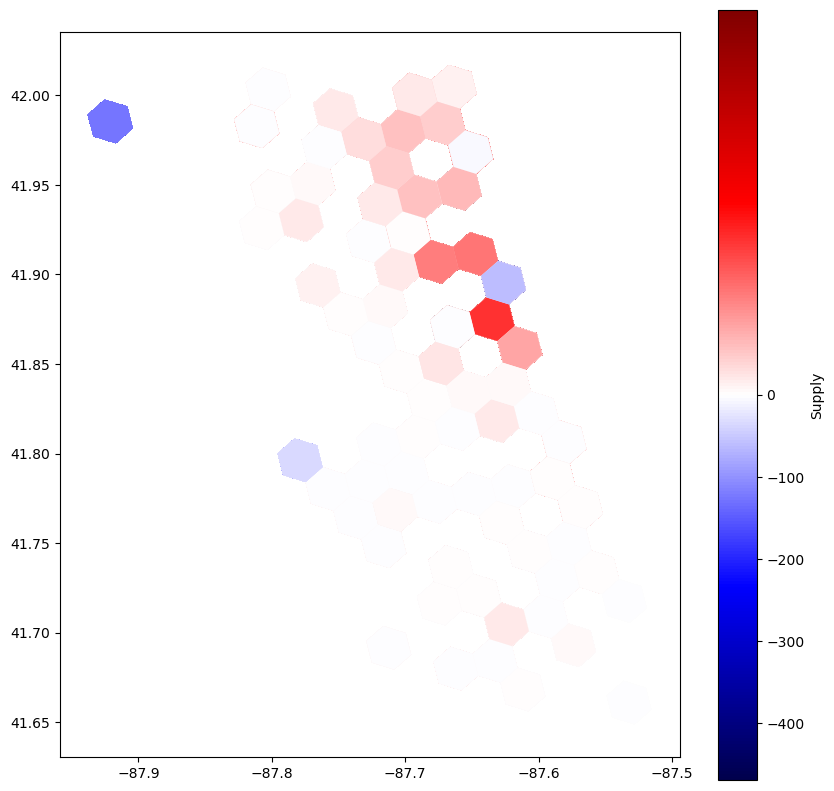

In [123]:
plot_gpd(taxi_by_h3_7_4H_gpd[taxi_by_h3_7_4H_gpd["hour"] == 0], "trip_amount_balance", "Supply", True, color_scheme="seismic")

In the early morning, the flow seems to be from the inner city to the outer city and even to out of the city. These are possibly people returning from a night out

<AxesSubplot: >

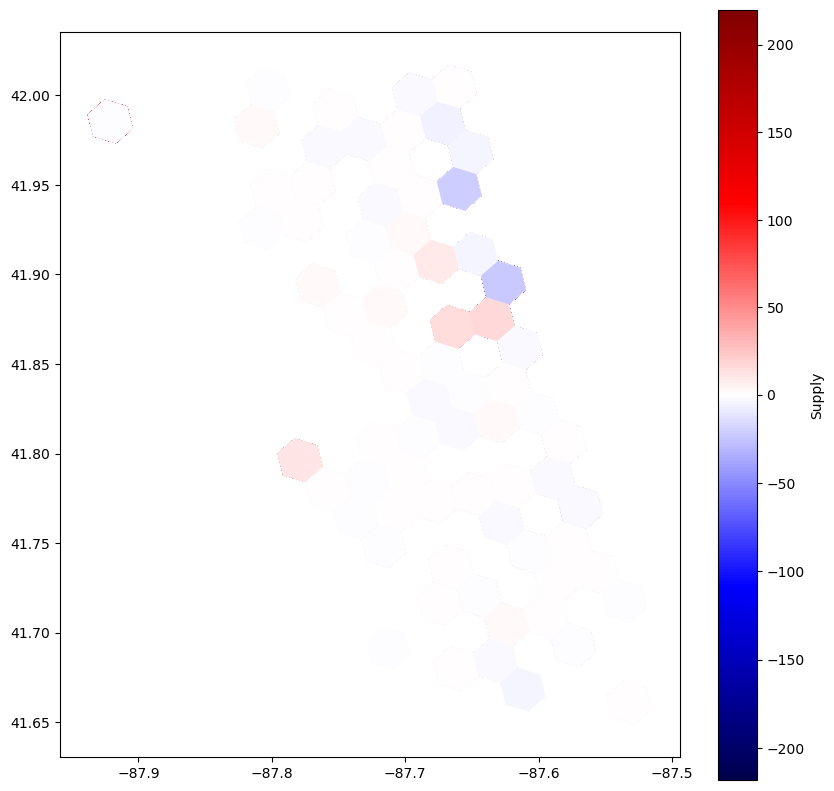

In [124]:
plot_gpd(taxi_by_h3_7_4H_gpd[taxi_by_h3_7_4H_gpd["hour"] == 4], "trip_amount_balance", "Supply", True, color_scheme="seismic")

In the morning it is then likely commuters who drive from out of the city and the outer city into the populated inner city.

<AxesSubplot: >

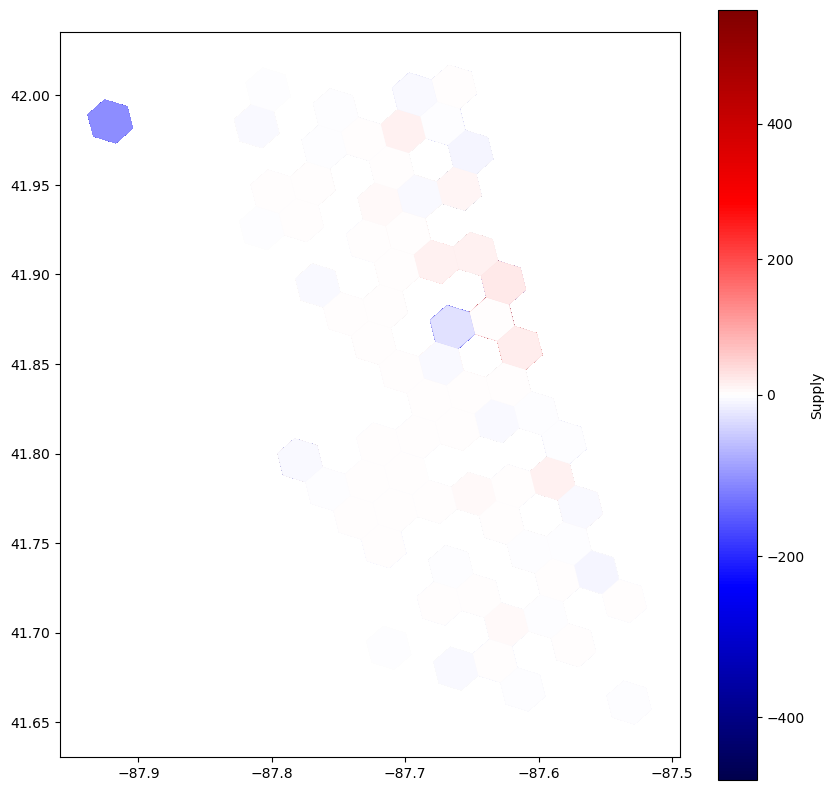

In [125]:
plot_gpd(taxi_by_h3_7_4H_gpd[taxi_by_h3_7_4H_gpd["hour"] == 8], "trip_amount_balance", "Supply", True, color_scheme="seismic")

Noon accelerates this trend and the inner city is now a highly popular destination, while many more drive into the city than out.

<AxesSubplot: >

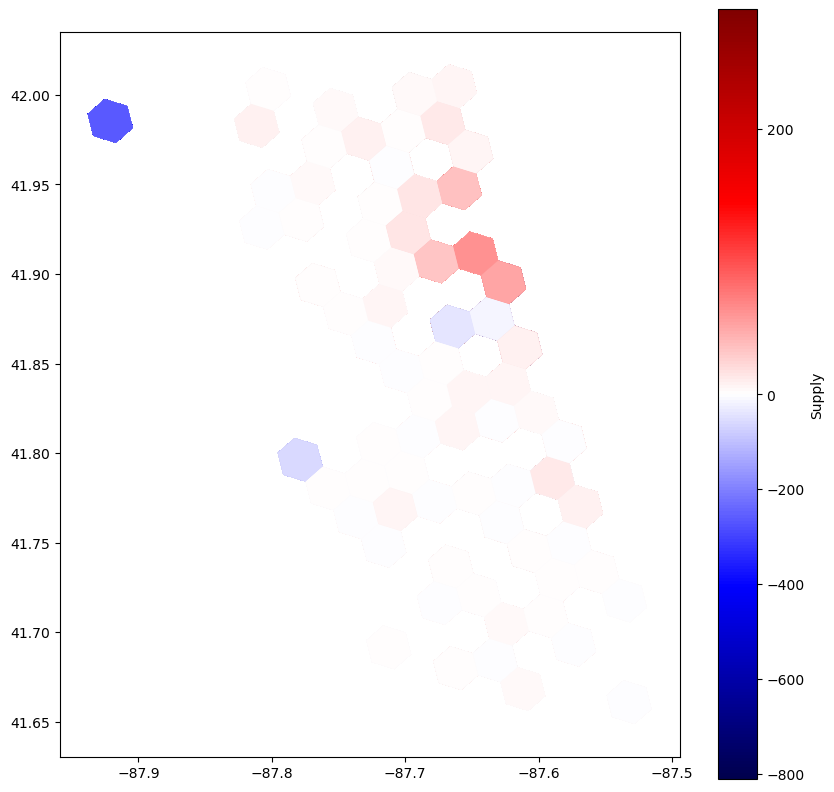

In [126]:
plot_gpd(taxi_by_h3_7_4H_gpd[taxi_by_h3_7_4H_gpd["hour"] == 12], "trip_amount_balance", "Supply", True, color_scheme="seismic")

The same trend continues for the afternoon, just with the outer city also becoming a bit more popular and the inner city less popular, likely also because of commuters returning.

<AxesSubplot: >

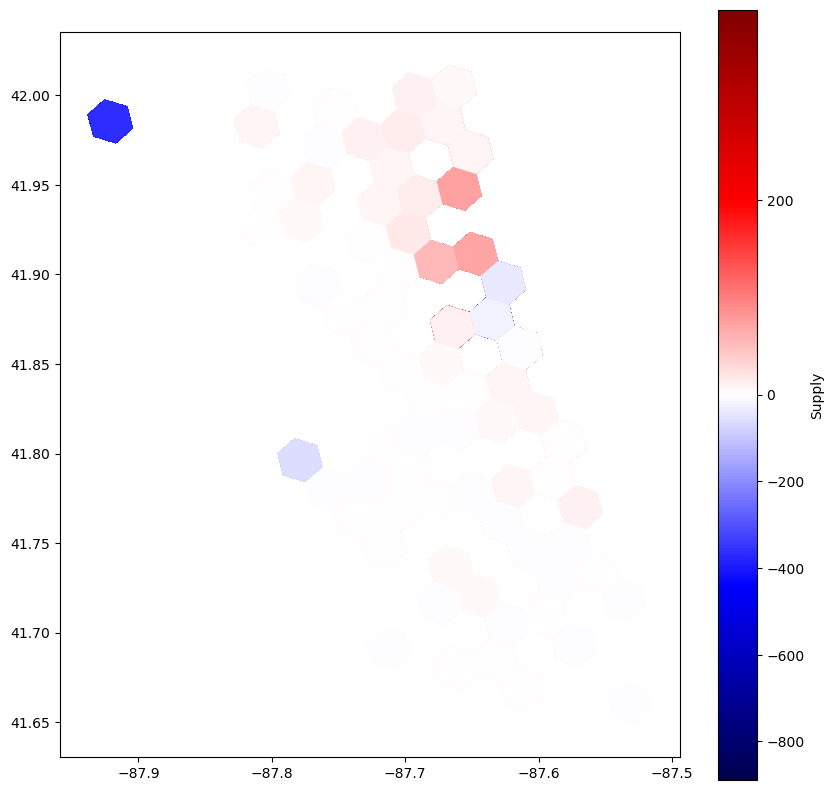

In [127]:
plot_gpd(taxi_by_h3_7_4H_gpd[taxi_by_h3_7_4H_gpd["hour"] == 16], "trip_amount_balance", "Supply", True, color_scheme="seismic")

In the evening, the inner city and the outer city remain popular, likely due to nightlife

<AxesSubplot: >

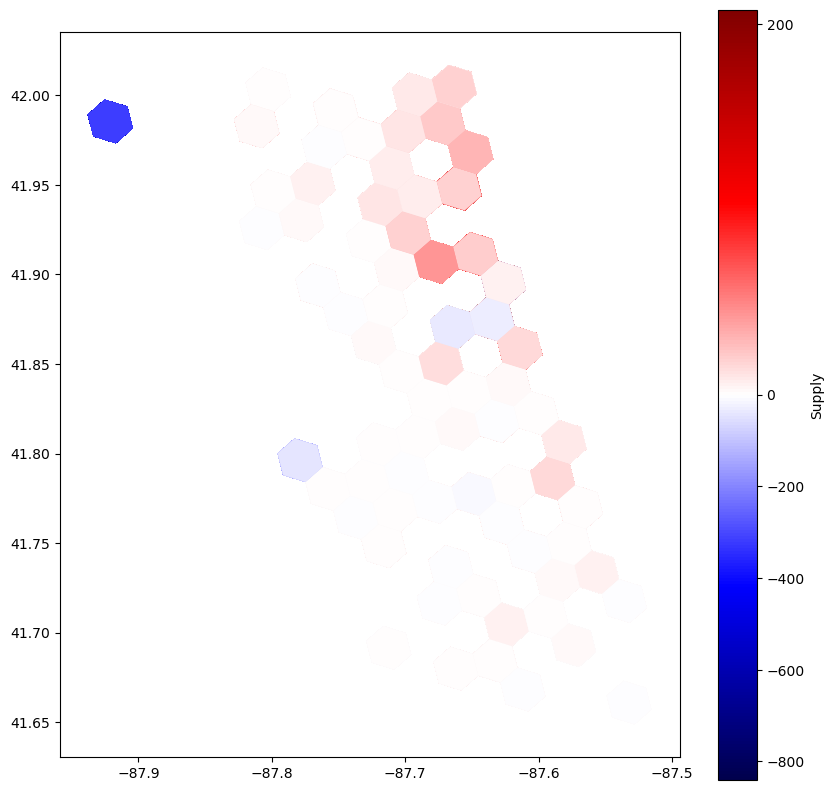

In [128]:
plot_gpd(taxi_by_h3_7_4H_gpd[taxi_by_h3_7_4H_gpd["hour"] == 20], "trip_amount_balance", "Supply", True, color_scheme="seismic")